# Data curation
Thi snotebook aims to curate all available protein-ligand binding data associated with experimental affinity values. 
Curation here implies to format experimental data and structure in a shared format before conducting standardization of structure.

# Functions

In [3]:
import os
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import math

def dg_to_kd(delta_g_kcal, temp_k=298.15):
    R = 1.987e-3  # kcal/mol·K
    kd_molar = -math.log10(math.exp(delta_g_kcal / (R * temp_k)))
    return kd_molar  # in Molar (M)

def prepare_wang_data(base_dir):
    data = []
    for target in tqdm(os.listdir(base_dir)):
        target_dir = os.path.join(base_dir, target)
        structures_dir = os.path.join(target_dir, "structures")
        dg_file = os.path.join(target_dir, "experimental_dG.txt")

        # Load ΔG values into a dictionary
        dg_dict = {}
        if os.path.isfile(dg_file):
            with open(dg_file, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        ligand_name = parts[0]
                        try:
                            dg_value = float(parts[1])
                            kd_value = dg_value  # RT = 0.592 kcal/mol at 298K
                            dg_dict[ligand_name] = kd_value
                        except ValueError:
                            continue

        if os.path.isdir(structures_dir):
            for ligand_folder in os.listdir(structures_dir):
                ligand_path = os.path.join(structures_dir, ligand_folder)
                sdf_path = os.path.join(ligand_path, "ligand.sdf")
                pdb_path = os.path.join(ligand_path, "protein.pdb")

                smiles = None
                if os.path.isfile(sdf_path):
                    supplier = Chem.SDMolSupplier(sdf_path)
                    mols = [mol for mol in supplier if mol is not None]
                    if mols:
                        smiles = Chem.MolToSmiles(mols[0])

                kd = dg_dict.get(ligand_folder, None)


                combine_pdb_sdf(pdb_path, sdf_path, pdb_path.replace("protein.pdb","complex.pdb"))

                data.append({
                    "protein_name": target,
                    "ligand": ligand_folder,
                    "smiles": smiles,
                    "ligand_sdf_path": sdf_path if os.path.isfile(sdf_path) else None,
                    "protein_pdb_path": pdb_path if os.path.isfile(pdb_path) else None,
                    "complex_pdb_path": pdb_path.replace("protein.pdb","complex.pdb"),
                    "pKd (Wang, FEP)":  dg_to_kd(kd, temp_k=298.15)
                })
                
    return(pd.DataFrame(data))
        

from rdkit import Chem
import os

from rdkit import Chem
def combine_pdb_sdf(protein_pdb_path, ligand_sdf_path, output_pdb_path):
    # Load ligand from SDF
    mol = Chem.MolFromMolFile(ligand_sdf_path, removeHs=False)
    if mol is None:
        raise ValueError("Invalid SDF file or molecule failed to load")

    # Set residue and chain info properly
    for i, atom in enumerate(mol.GetAtoms()):
        info = Chem.AtomPDBResidueInfo()
        info.SetName(" {:<2}".format(atom.GetSymbol()))  # Proper spacing
        info.SetResidueName("LIG")
        info.SetResidueNumber(1)
        info.SetChainId("A")  # <-- Important for dpocket
        info.SetIsHeteroAtom(True)
        atom.SetMonomerInfo(info)

    # Convert ligand to PDB block
    ligand_pdb_block = Chem.MolToPDBBlock(mol)

    # Combine protein and ligand
    with open(output_pdb_path, "w") as out:
        with open(protein_pdb_path, "r") as prot_file:
            for line in prot_file:
                if not line.startswith("END"):  # avoid duplicating END
                    out.write(line)
        out.write("\n")
        out.write(ligand_pdb_block)
        out.write("END\n")


import pandas as pd
from pathlib import Path

def build_hqbind_pose_dataset(metadata_path="HQBind/hiqbind_metadata.csv", root="HQBind/raw_data_hiq_sm"):
    df = pd.read_csv(metadata_path)

    pose_data = []
    for _, row in df.iterrows():
        pdbid = row["PDBID"]
        ligand_name = row["Ligand Name"]
        chain = row["Ligand Chain"]
        resnum = row["Ligand Residue Number"]

        ligand_dir = f"{pdbid}_{ligand_name}_{chain}_{resnum}"
        ligand_path = Path(root) / pdbid / ligand_dir / f"{ligand_dir}_ligand.pdb"
        protein_path = Path(root) / pdbid / ligand_dir / f"{ligand_dir}_protein.pdb"

        if not ligand_path.exists() or not protein_path.exists():
            continue

        pose_data.append({
            "PDBID": pdbid,
            "Resolution": row["Resolution"],
            "Ligand Name": ligand_name,
            "Ligand Chain": chain,
            "Ligand Residue Number": resnum,
            "Ligand SMILES": row["Ligand SMILES"],
            "Binding Affinity Measurement": row["Binding Affinity Measurement"],
            "Binding Affinity Sign": row["Binding Affinity Sign"],
            "Binding Affinity Value": row["Binding Affinity Value"],
            "Binding Affinity Unit": row["Binding Affinity Unit"],
            "Binding Affinity Source": row["Binding Affinity Source"],
            "Ligand PDB Path": str(ligand_path),
            "Protein PDB Path": str(protein_path)
        })

    return pd.DataFrame(pose_data)

def format_hqbind(df_pose):

    unit_to_M = {
    "M": 1,
    "mM": 1e-3,
    "uM": 1e-6,
    "nM": 1e-9,
    "pM": 1e-12
    }
    
    df_pose = df_pose[["Ligand PDB Path", "Protein PDB Path", "Ligand SMILES", "Resolution", "Binding Affinity Measurement", "Binding Affinity Sign", "Binding Affinity Value", "Binding Affinity Unit"]]
    df_pose["Binding Affinity (M)"] = df_pose.apply(
        lambda row: row["Binding Affinity Value"] * unit_to_M.get(row["Binding Affinity Unit"], None)
        if pd.notnull(row["Binding Affinity Value"]) and row["Binding Affinity Unit"] in unit_to_M
        else None,
        axis=1
    )
    

    df_pose["neg log10(M)"] = df_pose["Binding Affinity (M)"].apply(
        lambda x: -np.log10(x) if pd.notnull(x) and x > 0 else None
    )
    return(df_pose)


from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from tqdm import tqdm

def process_binding_data(df):
    tqdm.pandas()  

    # Keep only standard_relation == "="
    df = df[df["standard_relation"] == "="].copy()

    unit_to_multiplier = {
        "M": 1,
        "mM": 1e-3,
        "uM": 1e-6,
        "µM": 1e-6,
        "nM": 1e-9,
        "pM": 1e-12,
        "fM": 1e-15,
        "ug.mL-1": None,
        "mg.mL-1": None,
    }

    def to_molar(row):
        unit = row["standard_units"]
        val = row["standard_value"]
        mw = row["Molecule MW"]
        if pd.isna(val) or pd.isna(unit) or pd.isna(mw):
            return np.nan
        if unit in unit_to_multiplier and unit_to_multiplier[unit] is not None:
            return float(val) * unit_to_multiplier[unit]
        elif unit == "ug.mL-1":
            return (float(val) * 1e-6) / mw
        elif unit == "mg.mL-1":
            return (float(val) * 1e-3) / mw
        else:
            return np.nan

    df["Molar"] = df.apply(to_molar, axis=1)
    df["-log10(M)"] = -np.log10(df["Molar"])

    def path(row, ext):
        return f"../data/raw/BindingNetv1/BindingNetv1/{row['Protein Source']}/target_{row['Target ChEMBLID']}/{row['Molecule ChEMBLID']}/{row['Protein Source']}_{row['Target ChEMBLID']}_{row['Molecule ChEMBLID']}.{ext}"

    df["SDF_path"] = df.progress_apply(lambda r: path(r, "sdf"), axis=1)
    df["PDB_path"] = df.progress_apply(lambda r: path(r, "pdb"), axis=1)

    # Group by standard_type
    grouped = {std_type: group.reset_index(drop=True) for std_type, group in df.groupby("standard_type")}
    return grouped


def process_binding_data_bindingdnetv2(df):
    tqdm.pandas()  
    # Keep only standard_relation == "="
    df = df[df["standard_relation"] == "="].copy()

    unit_to_multiplier = {
        "M": 1,
        "mM": 1e-3,
        "uM": 1e-6,
        "µM": 1e-6,
        "nM": 1e-9,
        "pM": 1e-12,
        "fM": 1e-15,
        "ug.mL-1": None,
        "mg.mL-1": None,
    }

    def to_molar(row):
        unit = row["standard_units"]
        val = row["standard_value"]
        mw = row["Molecule MW"]
        if pd.isna(val) or pd.isna(unit) or pd.isna(mw):
            return np.nan
        if unit in unit_to_multiplier and unit_to_multiplier[unit] is not None:
            return float(val) * unit_to_multiplier[unit]
        elif unit == "ug.mL-1":
            return (float(val) * 1e-6) / mw
        elif unit == "mg.mL-1":
            return (float(val) * 1e-3) / mw
        else:
            return np.nan

    df["Molar"] = df.apply(to_molar, axis=1)
    df["-log10(M)"] = -np.log10(df["Molar"])

    def file_exists_for(row, level):
        sdf_path = f"../data/raw/BindingNetv2/{level}/{row['Protein Source']}/target_{row['Target ChEMBLID']}/{row['Molecule ChEMBLID']}/{row['Protein Source']}_{row['Target ChEMBLID']}_{row['Molecule ChEMBLID']}.sdf"
        pdb_path = f"../data/raw/BindingNetv2/{level}/{row['Protein Source']}/target_{row['Target ChEMBLID']}/{row['Molecule ChEMBLID']}/{row['Protein Source']}_{row['Target ChEMBLID']}_{row['Molecule ChEMBLID']}.pdb"
        return os.path.exists(sdf_path) and os.path.exists(pdb_path)

    def resolve_high_low(row):
        return "high" if file_exists_for(row, "high") else "moderate" if file_exists_for(row, "moderate") else None

    df["high_low"] = df.progress_apply(resolve_high_low, axis=1)
    df = df[df["high_low"].notna()].copy()

    
    def path(row, ext):
        return f"../data/raw/BindingNetv2/{row['high_low']}/{row['Protein Source']}/target_{row['Target ChEMBLID']}/{row['Molecule ChEMBLID']}/{row['Protein Source']}_{row['Target ChEMBLID']}_{row['Molecule ChEMBLID']}.{ext}"
    import os


    df["SDF_path"] = df.progress_apply(lambda r: path(r, "sdf"), axis=1)
    df["PDB_path"] = df.progress_apply(lambda r: path(r, "pdb"), axis=1)

    # Group by standard_type
    grouped = {std_type: group.reset_index(drop=True) for std_type, group in df.groupby("standard_type")}
    return grouped

import os

def process_binding_data_bindingdnetv2(df):
    tqdm.pandas()
    # Keep only standard_relation == "="
    df = df[df["standard_relation"] == "="].copy()

    unit_to_multiplier = {
        "M": 1,
        "mM": 1e-3,
        "uM": 1e-6,
        "µM": 1e-6,
        "nM": 1e-9,
        "pM": 1e-12,
        "fM": 1e-15,
        "ug.mL-1": None,
        "mg.mL-1": None,
    }

    def to_molar(row):
        unit = row["standard_units"]
        val = row["standard_value"]
        mw = row["Molecule MW"]
        if pd.isna(val) or pd.isna(unit) or pd.isna(mw):
            return np.nan
        if unit in unit_to_multiplier and unit_to_multiplier[unit] is not None:
            return float(val) * unit_to_multiplier[unit]
        elif unit == "ug.mL-1":
            return (float(val) * 1e-6) / mw
        elif unit == "mg.mL-1":
            return (float(val) * 1e-3) / mw
        else:
            return np.nan

    df["Molar"] = df.apply(to_molar, axis=1)
    df["-log10(M)"] = -np.log10(df["Molar"])

    def file_exists_for(row, level):
        target_id = row['Target ChEMBLID']
        mol_id = row['Molecule ChEMBLID']
        base = f"../data/raw/BindingNetv2/{level}/target_{target_id}/{mol_id}"
        return os.path.exists(f"{base}/ligand.sdf") and os.path.exists(f"{base}/protein.pdb")

    def path(row, ext):
        return f"../data/raw/BindingNetv2/{row['high_low']}/target_{row['Target ChEMBLID']}/{row['Molecule ChEMBLID']}/{ext}"

    def resolve_high_low(row):
        return "high" if file_exists_for(row, "high") else "moderate" if file_exists_for(row, "moderate") else None

    df["high_low"] = df.progress_apply(resolve_high_low, axis=1)
    df = df[df["high_low"].notna()].copy()


    df["SDF_path"] = df.progress_apply(lambda r: path(r, "ligand.sdf"), axis=1)
    df["PDB_path"] = df.progress_apply(lambda r: path(r, "protein.pdb"), axis=1)

    # Group by standard_type
    grouped = {std_type: group.reset_index(drop=True) for std_type, group in df.groupby("standard_type")}
    return grouped, df


import os
import pandas as pd
from tqdm import tqdm
import re


def perpare_refined_PDBbind2020():
    base_dir = '../data/raw/PDBbind2020/PDBbind2020/main'

    index_file = os.path.join(base_dir, 'index', 'INDEX_refined_data.2020')
    refined_dir = os.path.join(base_dir, 'refined-set')

    records = []

    with open(index_file, 'r') as f:
        for line in tqdm(f):
            if line.startswith('#') or not line.strip():
                continue

            # Split by multiple spaces
            parts = re.split(r'\s{2,}', line.strip())
            if len(parts) < 5:
                continue

            try:
                pdbid = parts[0]
                resolution = float(parts[1])
                year = int(parts[2])
                log_affinity = float(parts[3])
                binding_str = parts[4]
            except:
                continue  # Skip malformed rows

            # Parse binding string like "Ki=0.1uM", "Ki<=100nM"
            if '=' in binding_str:
                activity_part, value_unit_part = binding_str.split('=')
                activity_type = activity_part.strip().replace("<", "").replace(">", "")
                value_unit_part = value_unit_part.strip().replace("<", "").replace(">", "")
                value_str = ''.join(filter(lambda x: x in '0123456789.-', value_unit_part))
                unit = ''.join(filter(lambda x: x.isalpha(), value_unit_part))

                try:
                    value = float(value_str)
                except ValueError:
                    continue  # skip invalid value
            else:
                continue

            # File paths
            protein_path = os.path.join(refined_dir, pdbid, f"{pdbid}_protein.pdb")
            ligand_path = os.path.join(refined_dir, pdbid, f"{pdbid}_ligand.sdf")

            if not os.path.exists(protein_path) or not os.path.exists(ligand_path):
                continue

            records.append({
                'pdbid': pdbid,
                'resolution': resolution,
                'year': year,
                '-log_affinity': log_affinity,
                'activity_type': activity_type,
                'value': value,
                'unit': unit,
                'protein_path': protein_path,
                'ligand_path': ligand_path
            })

    df = pd.DataFrame(records)
    import numpy as np

    unit_multipliers = {
        'M': 1,
        'mM': 1e-3,
        'uM': 1e-6,
        'nM': 1e-9,
        'pM': 1e-12,
        'fM': 1e-15
    }

    def convert_to_molar(row):
        factor = unit_multipliers.get(row['unit'], None)
        if factor is None or row['value'] <= 0:
            return None
        return -np.log10(row['value'] * factor)

    df['-log10_affinity_M'] = df.apply(convert_to_molar, axis=1)
    df
    return(df)


import os
import pandas as pd
import re
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

def parse_affinity_column(entry):
    if pd.isna(entry):
        return {}

    pattern = r"(Ki|Kd|IC50|EC50)=([0-9eE\.\+\-]+)([a-zA-Zμµ]*)"
    result = {}
    for match in re.finditer(pattern, entry):
        aff_type, val_str, unit = match.groups()
        try:
            val = float(val_str)
            result[f"{aff_type}_value"] = val
            result[f"{aff_type}_unit"] = unit.strip()
        except ValueError:
            continue
    return result

def convert_to_log_molar(value, unit):
    unit_map = {
        'M': 1,
        'mM': 1e-3,
        'uM': 1e-6,
        'μM': 1e-6,
        'µM': 1e-6,
        'nM': 1e-9,
        'pM': 1e-12,
        'fM': 1e-15
    }
    if unit not in unit_map or value <= 0:
        return None
    return -np.log10(value * unit_map[unit])

def extract_smiles_from_pdb(pdb_file):
    try:
        mol = Chem.MolFromPDBFile(pdb_file, removeHs=False)
        if mol is None:
            return None
        Chem.SanitizeMol(mol)
        return Chem.MolToSmiles(mol)
    except:
        return None

def process_biolip_dataset(biolip_path, ligand_dir, receptor_dir):
    col_names = [
        "pdb_id", "receptor_chain", "resolution", "binding_site_id", "ligand_id",
        "ligand_chain", "ligand_serial", "bs_residues_pdb", "bs_residues_renum",
        "catalytic_residues_pdb", "catalytic_residues_renum", "ec_number",
        "go_terms", "affinity_lit", "affinity_moad", "affinity_pdbbind",
        "affinity_bindingdb", "uniprot_id", "pubmed_id", "ligand_seq_number",
        "receptor_sequence"
    ]

    df = pd.read_csv(biolip_path, sep="\t", header=None, names=col_names)

    # Extract affinities
    sources = ["affinity_lit", "affinity_moad", "affinity_pdbbind", "affinity_bindingdb"]
    for src in sources:
        parsed = df[src].apply(parse_affinity_column)
        parsed_df = parsed.apply(pd.Series).add_prefix(f"{src}_")
        df = pd.concat([df, parsed_df], axis=1)

    # Output dict
    result_dfs = {
        'Ki': [],
        'Kd': [],
        'IC50': [],
        'EC50': []
    }

    for _, row in tqdm(df.iterrows()):
        pdb_id = row["pdb_id"]
        ligand_id = row["ligand_id"]
        receptor_chain = row["receptor_chain"]

        ligand_fname = f"{pdb_id}_{ligand_id}_{row['ligand_chain']}_{row['ligand_serial']}.pdb"
        receptor_fname = f"{pdb_id}{receptor_chain}.pdb"

        ligand_path = os.path.join(ligand_dir, ligand_fname)
        receptor_path = os.path.join(receptor_dir, receptor_fname)

        if not os.path.exists(ligand_path) or not os.path.exists(receptor_path):
            continue

        smiles = extract_ligands_from_pdb(ligand_path)
        if smiles is None:
            continue

        for aff_type in result_dfs.keys():
            # Try from all sources
            for source in sources:
                val_key = f"{source}_{aff_type}_value"
                unit_key = f"{source}_{aff_type}_unit"
                value = row.get(val_key)
                unit = row.get(unit_key)
                if pd.notna(value) and pd.notna(unit):
                    log_aff = convert_to_log_molar(value, unit)
                    if log_aff is not None:
                        result_dfs[aff_type].append({
                            "protein_path": receptor_path,
                            "ligand_path": ligand_path,
                            "smiles": smiles,
                            "-log10_affinity_M": log_aff
                        })
                        break  # stop at first valid source

    # Create dataframes
    return {k: pd.DataFrame(v) for k, v in result_dfs.items()}


def extract_ligands_from_pdb(file_path):
    from rdkit import Chem
    import os

    smiles_list = []

    if not os.path.isfile(file_path):
        return [None]

    ext = os.path.splitext(file_path)[-1].lower()

    try:
        if file_path.endswith('.sdf'):
            suppl = Chem.SDMolSupplier(file_path, sanitize=False, removeHs=True)
            if isinstance(suppl, list) or hasattr(suppl, '__iter__'):
                for mol in suppl:
                    if mol:
                        smiles_list.append(Chem.MolToSmiles(mol))
                        break
            else:
                smiles_list.append(Chem.MolToSmiles(suppl))

        elif file_path.endswith('.pdb'):
            suppl = Chem.MolFromPDBFile(file_path, sanitize=False, removeHs=True)
            if isinstance(suppl, list) or hasattr(suppl, '__iter__'):
                for mol in suppl:
                    if mol:
                        smiles_list.append(Chem.MolToSmiles(mol))
                        break
            else:
                smiles_list.append(Chem.MolToSmiles(suppl))
        else:
            smiles_list.append(None)

    except Exception:
        smiles_list.append(None)

    return smiles_list[0]


In [4]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
import pickle
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import required libraries
from rdkit import Chem
from rdkit.Chem import rdmolfiles
from Bio.PDB import MMCIFParser, PDBIO, Select

class ProteinSelect(Select):
    def accept_residue(self, residue):
        return residue.get_id()[0] == ' '

class LigandSelect(Select):
    def accept_residue(self, residue):
        return residue.get_id()[0] != ' '

def check_files_exist_and_valid(protein_path, ligand_path, min_size_bytes=50):
    """Check if both protein and ligand files exist and are valid"""
    try:
        if not (os.path.exists(protein_path) and os.path.exists(ligand_path)):
            return False
        
        protein_size = os.path.getsize(protein_path)
        ligand_size = os.path.getsize(ligand_path)
        
        if protein_size < min_size_bytes or ligand_size < min_size_bytes:
            return False
            
        # Quick content validation
        try:
            with open(protein_path, 'r') as f:
                first_line = f.readline().strip()
                if not (first_line.startswith(('ATOM', 'HETATM', 'MODEL', 'HEADER'))):
                    return False
            
            with open(ligand_path, 'r') as f:
                content = f.read(100)
                if len(content.strip()) < 10:
                    return False
                    
        except Exception:
            return False
            
        return True
        
    except Exception:
        return False

def process_single_cif(cif_path, protein_dir, ligand_dir):
    """Process a single CIF file"""
    
    cif_filename = os.path.basename(cif_path)
    pdb_filename = cif_filename.replace(".cif", ".pdb")
    sdf_filename = cif_filename.replace(".cif", ".sdf")
    
    pdb_path = os.path.join(protein_dir, pdb_filename)
    sdf_path = os.path.join(ligand_dir, sdf_filename)
    
    # Skip if files already exist and are valid
    if check_files_exist_and_valid(pdb_path, sdf_path):
        return {
            'protein_path': pdb_path,
            'ligand_path': sdf_path,
            'status': 'already_exists',
            'success': True
        }
    
    # Clean up any partially created files
    for path in [pdb_path, sdf_path]:
        if os.path.exists(path) and os.path.getsize(path) < 50:
            try:
                os.remove(path)
            except:
                pass
    
    try:
        # Parse CIF file
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure("complex", cif_path)
        
        # Write protein PDB
        io = PDBIO()
        io.set_structure(structure)
        io.save(pdb_path, select=ProteinSelect())
        
        # Write ligand to temporary PDB first
        ligand_temp_pdb = sdf_path.replace(".sdf", "_temp.pdb")
        io.save(ligand_temp_pdb, select=LigandSelect())
        
        # Convert ligand PDB to SDF using RDKit
        mol = rdmolfiles.MolFromPDBFile(ligand_temp_pdb, removeHs=False)
        
        if mol is not None:
            writer = Chem.SDWriter(sdf_path)
            writer.write(mol)
            writer.close()
            
            # Clean up temp file
            if os.path.exists(ligand_temp_pdb):
                os.remove(ligand_temp_pdb)
            
            # Final validation
            if check_files_exist_and_valid(pdb_path, sdf_path):
                return {
                    'protein_path': pdb_path,
                    'ligand_path': sdf_path,
                    'status': 'converted_successfully',
                    'success': True
                }
            else:
                return {
                    'protein_path': pdb_path,
                    'ligand_path': sdf_path,
                    'status': 'validation_failed',
                    'success': False
                }
        else:
            # RDKit conversion failed
            if os.path.exists(ligand_temp_pdb):
                os.remove(ligand_temp_pdb)
            return {
                'protein_path': pdb_path,
                'ligand_path': sdf_path,
                'status': 'rdkit_failed',
                'success': False
            }
            
    except Exception as e:
        # Clean up any partial files
        for path in [pdb_path, sdf_path]:
            if os.path.exists(path):
                try:
                    os.remove(path)
                except:
                    pass
                    
        return {
            'protein_path': pdb_path,
            'ligand_path': sdf_path,
            'status': f'error: {str(e)[:30]}',
            'success': False
        }

class SimpleSAIRProcessor:
    """Simple row-by-row SAIR processor"""
    
    def __init__(self, csv_path, structure_dir, output_dir):
        self.csv_path = csv_path
        self.structure_dir = structure_dir
        self.output_dir = output_dir
        
        # Set up directories
        self.protein_dir = os.path.join(output_dir, "protein")
        self.ligand_dir = os.path.join(output_dir, "ligand")
        
        Path(self.protein_dir).mkdir(parents=True, exist_ok=True)
        Path(self.ligand_dir).mkdir(parents=True, exist_ok=True)
        
        self.checkpoint_file = f"{output_dir}/simple_checkpoint.pkl"
        
        print(f"🔬 Simple SAIR Processor initialized")
        print(f"📁 Output: {output_dir}")
    
    def get_available_cif_files(self):
        """Get all CIF files actually available in the structure directory"""
        print("📂 Scanning structure directory for CIF files...")
        
        cif_files = []
        if os.path.exists(self.structure_dir):
            for file in os.listdir(self.structure_dir):
                if file.endswith('.cif'):
                    cif_files.append(file)
        
        print(f"Found {len(cif_files):,} CIF files in structure directory")
        return set(cif_files)  # Return as set for fast lookup
    
    def filter_dataframe_by_available_files(self):
        """Filter experimental data to only include rows with existing CIF files"""
        print("📊 Loading experimental data...")
        df_exp = pd.read_csv(self.csv_path)
        print(f"Original dataset: {len(df_exp):,} entries")
        
        # Get available CIF files
        available_cifs = self.get_available_cif_files()
        
        # Filter dataframe
        print("🔍 Filtering data by available CIF files...")
        
        # Extract CIF filename from path and check if it exists
        def cif_exists(path):
            cif_filename = os.path.basename(path)
            return cif_filename in available_cifs
        
        df_filtered = df_exp[df_exp['path'].apply(cif_exists)].copy()
        
        print(f"Filtered dataset: {len(df_filtered):,} entries")
        print(f"Removed {len(df_exp) - len(df_filtered):,} entries without CIF files")
        
        return df_filtered
    
    def check_existing_processed(self, df):
        """Check how many files are already processed"""
        print("🔍 Checking existing processed files...")
        
        existing_count = 0
        for idx, row in df.iterrows():
            cif_filename = os.path.basename(row["path"])
            pdb_filename = cif_filename.replace(".cif", ".pdb")
            sdf_filename = cif_filename.replace(".cif", ".sdf")
            
            pdb_path = os.path.join(self.protein_dir, pdb_filename)
            sdf_path = os.path.join(self.ligand_dir, sdf_filename)
            
            if check_files_exist_and_valid(pdb_path, sdf_path):
                existing_count += 1
        
        print(f"Already processed: {existing_count:,}/{len(df):,} ({existing_count/len(df)*100:.1f}%)")
        return existing_count
    
    def process_all_simple(self, save_every=1000):
        """Simple row-by-row processing with minimal output"""
        
        print("🚀 Starting simple row-by-row processing...")
        
        # Filter data by available CIF files
        df_filtered = self.filter_dataframe_by_available_files()
        
        if len(df_filtered) == 0:
            print("❌ No matching CIF files found!")
            return None, None
        
        # Check existing processed files
        existing_count = self.check_existing_processed(df_filtered)
        
        # Initialize tracking
        results = {}
        processed_count = 0
        success_count = existing_count
        start_time = time.time()
        
        # Load checkpoint if exists
        if os.path.exists(self.checkpoint_file):
            try:
                with open(self.checkpoint_file, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                    results = checkpoint_data.get('results', {})
                    processed_count = len(results)
                print(f"📋 Loaded checkpoint: {processed_count:,} files in progress")
            except:
                print("⚠️ Could not load checkpoint, starting fresh")
        
        print(f"⚡ Processing {len(df_filtered):,} entries...")
        print("🔄 Progress will be shown every 1000 files")
        
        # Process row by row
        with tqdm(total=len(df_filtered), desc="Processing", 
                  initial=processed_count, unit="files") as pbar:
            
            for idx, row in df_filtered.iterrows():
                # Skip if already processed
                if idx in results:
                    continue
                
                cif_path = os.path.join(self.structure_dir, os.path.basename(row["path"]))
                
                # Process the file
                result = process_single_cif(cif_path, self.protein_dir, self.ligand_dir)
                results[idx] = result
                
                if result['success']:
                    success_count += 1
                
                processed_count += 1
                pbar.update(1)
                
                # Update progress info occasionally
                if processed_count % 100 == 0:
                    pbar.set_postfix({
                        'Success': f"{success_count:,}",
                        'Rate': f"{success_count/processed_count*100:.1f}%"
                    })
                
                # Save checkpoint periodically
                if processed_count % save_every == 0:
                    self.save_checkpoint(results, processed_count)
        
        # Final save
        self.save_checkpoint(results, processed_count)
        
        # Print summary
        elapsed_time = time.time() - start_time
        print(f"\n🎉 Processing complete!")
        print(f"  Total entries processed: {processed_count:,}")
        print(f"  Successfully converted: {success_count:,}")
        print(f"  Success rate: {success_count/len(df_filtered)*100:.1f}%")
        print(f"  Processing time: {elapsed_time/60:.1f} minutes")
        print(f"  Rate: {processed_count/elapsed_time:.1f} files/second")
        
        return self.create_final_dataframe(df_filtered, results)
    
    def save_checkpoint(self, results, processed_count):
        """Save checkpoint"""
        checkpoint_data = {
            'results': results,
            'processed_count': processed_count,
            'timestamp': time.time()
        }
        
        with open(self.checkpoint_file, 'wb') as f:
            pickle.dump(checkpoint_data, f)
    
    def create_final_dataframe(self, df_filtered, results):
        """Create final processed dataframe"""
        print("\n📋 Creating final datasets...")
        
        # Add result paths to dataframe
        protein_paths = []
        ligand_paths = []
        success_flags = []
        
        for idx, row in df_filtered.iterrows():
            if idx in results and results[idx]['success']:
                protein_paths.append(results[idx]['protein_path'])
                ligand_paths.append(results[idx]['ligand_path'])
                success_flags.append(True)
            else:
                protein_paths.append('')
                ligand_paths.append('')
                success_flags.append(False)
        
        df_filtered['protein_pdb_path'] = protein_paths
        df_filtered['ligand_sdf_path'] = ligand_paths
        df_filtered['conversion_success'] = success_flags
        
        # Keep only successful conversions
        df_final = df_filtered[df_filtered['conversion_success']].copy()
        df_final = df_final[["protein_pdb_path", "ligand_sdf_path", "SMILES", "potency", "assay"]]
        
        print(f"✅ Final dataset: {len(df_final):,} valid entries")
        
        # Split by assay type and save
        assay_types = ["biochem", "na", "cell", "homogenate"]
        split_dfs = {}
        
        for assay in assay_types:
            df_assay = df_final[df_final["assay"] == assay].copy()
            if len(df_assay) > 0:
                df_assay = df_assay.rename(columns={"potency": f"potency ({assay})"})
                split_dfs[assay] = df_assay
                
                # Save to CSV
                output_csv = f"{self.output_dir}/{assay}_data.csv"
                df_assay.to_csv(output_csv, index=False)
                print(f"💾 Saved {len(df_assay):,} {assay} entries")
        
        # Save complete dataset
        complete_csv = f"{self.output_dir}/complete_processed_data.csv"
        df_final.to_csv(complete_csv, index=False)
        print(f"💾 Saved complete dataset")
        
        return df_final, split_dfs

# Convenience function for Jupyter
def run_simple_processing(csv_path, structure_dir, output_dir):
    """Run simple processing"""
    processor = SimpleSAIRProcessor(csv_path, structure_dir, output_dir)
    return processor.process_all_simple()

def quick_check_available_files(csv_path, structure_dir):
    """Quick check of available files"""
    processor = SimpleSAIRProcessor(csv_path, structure_dir, "/tmp")
    df_filtered = processor.filter_dataframe_by_available_files()
    return len(df_filtered)

## 1. Wang 2015 FEP - Ross structures (from dG to Kd using Gibbs)

In [13]:
base_dir = "../data/raw/Wang_2015_Ross_structures"
df = prepare_wang_data(base_dir)
df = df[["protein_pdb_path","ligand_sdf_path", "smiles", "pKd (Wang, FEP)"]]
print(df.columns.tolist())
df["resolution"] = None
df.to_parquet("../data/curated/exp/pKd_FEP_Wang_2015.parquet", index = False)
df.head(1)

  0%|          | 0/8 [00:00<?, ?it/s]

['protein_pdb_path', 'ligand_sdf_path', 'smiles', 'pKd (Wang, FEP)']


,protein_pdb_path,ligand_sdf_path,smiles,"pKd (Wang, FEP)",resolution
0,../data/raw/Wang_2015_Ross_structures/MCL1/str...,../data/raw/Wang_2015_Ross_structures/MCL1/str...,O=C([O-])c1[nH]c2ccccc2c1CCCOc1ccc(C(F)(F)F)cc1,5.036263,None


## 2. Zariquiey structures extended from Wang 2015 (from dG to Kd using Gibbs)

In [14]:
base_dir = "../data/raw/Wang_2015_Zariquiey_structures_extended"
df = prepare_wang_data(base_dir)
df = df[["protein_pdb_path","ligand_sdf_path", "smiles", "pKd (Wang, FEP)"]]
print(df.columns.tolist())
df["resolution"] = None
df.to_parquet("../data/curated/exp/pKd_FEP_Zariquiey_extended_Wang_2015.parquet", index = False)
df.head(1)

  0%|          | 0/8 [00:00<?, ?it/s]

['protein_pdb_path', 'ligand_sdf_path', 'smiles', 'pKd (Wang, FEP)']


,protein_pdb_path,ligand_sdf_path,smiles,"pKd (Wang, FEP)",resolution
0,../data/raw/Wang_2015_Zariquiey_structures_ext...,../data/raw/Wang_2015_Zariquiey_structures_ext...,Cc1cc(OCCCc2c(C(=O)[O-])sc3cc(Cl)ccc23)cc(C)c1Cl,6.641709,None


## 3. PDBbind2020

In [15]:
df = perpare_refined_PDBbind2020()
df['smiles'] = [extract_ligands_from_pdb(i) for i in tqdm(df["ligand_path"].tolist())]

0it [00:00, ?it/s]

  0%|          | 0/5316 [00:00<?, ?it/s]

[16:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[16:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

In [16]:
df.columns.tolist()

['pdbid',
 'resolution',
 'year',
 '-log_affinity',
 'activity_type',
 'value',
 'unit',
 'protein_path',
 'ligand_path',
 '-log10_affinity_M',
 'smiles']

a. pKi

In [17]:
df_Ki = df[df["activity_type"]=="Ki"]
df_Ki = df_Ki[["protein_path","ligand_path", "smiles", "-log10_affinity_M", 'resolution']]
df_Ki.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKi", 'resolution']
df_Ki.to_parquet("../data/curated/exp/pKi_PDBbind2020.parquet", index = False)
df_Ki.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKi,resolution
2,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]N1C(C([H])([H])[H])=C(C([H])([H])C([H])([H]...,2.0,1.31


b. pKd

In [18]:
df_Kd = df[df["activity_type"]=="Kd"]
df_Kd = df_Kd[["protein_path","ligand_path", "smiles", "-log10_affinity_M", 'resolution']]
df_Kd.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKd", 'resolution']
df_Kd.to_parquet("../data/curated/exp/pKd_PDBbind2020.parquet", index = False)
df_Kd.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKd,resolution
0,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]OC(=O)[C@]([H])(C([H])([H])C([H])([H])C([H]...,2.0,2.0


## 4. HQBind 

In [19]:
metadata_path="../data/raw/HiQBind//hiqbind_metadata.csv"
root_path="../data/raw/HiQBind//raw_data_hiq_sm"

df = build_hqbind_pose_dataset(metadata_path, root_path)
df = format_hqbind(df)

In [20]:
print(df.columns.tolist())

['Ligand PDB Path', 'Protein PDB Path', 'Ligand SMILES', 'Resolution', 'Binding Affinity Measurement', 'Binding Affinity Sign', 'Binding Affinity Value', 'Binding Affinity Unit', 'Binding Affinity (M)', 'neg log10(M)']


a. pKi

In [21]:
df_Ki = df[df["Binding Affinity Measurement"]=="ki"]
df_Ki = df_Ki[["Protein PDB Path","Ligand PDB Path", "Ligand SMILES", "neg log10(M)", "Resolution"]]
df_Ki.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKi", "resolution"]
df_Ki.to_parquet("../data/curated/exp/pKi_HiQBind.parquet", index = False)
df_Ki.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKi,resolution
4,../data/raw/HiQBind/raw_data_hiq_sm/1add/1add_...,../data/raw/HiQBind/raw_data_hiq_sm/1add/1add_...,Nc1ccnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,6.744727,2.4


b. pKd

In [22]:
df_Kd = df[df["Binding Affinity Measurement"]=="kd"]
df_Kd = df_Kd[["Protein PDB Path","Ligand PDB Path", "Ligand SMILES", "neg log10(M)", "Resolution"]]
df_Kd.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKd", "resolution"]
df_Kd.to_parquet("../data/curated/exp/pKd_HiQBind.parquet", index = False)
df_Kd.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKd,resolution
0,../data/raw/HiQBind/raw_data_hiq_sm/182l/182l_...,../data/raw/HiQBind/raw_data_hiq_sm/182l/182l_...,c1ccc2occc2c1,3.94939,1.8


c. pIC50

In [23]:
df_IC50 = df[df["Binding Affinity Measurement"]=="ic50"]
df_IC50 = df_IC50[["Protein PDB Path","Ligand PDB Path", "Ligand SMILES", "neg log10(M)", "Resolution"]]
df_IC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pIC50", "resolution"]
df_IC50.to_parquet("../data/curated/exp/pIC50_HiQBind.parquet", index = False)
df_IC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pIC50,resolution
5,../data/raw/HiQBind/raw_data_hiq_sm/1ah3/1ah3_...,../data/raw/HiQBind/raw_data_hiq_sm/1ah3/1ah3_...,COc1ccc2c(C(=S)N(C)CC(=O)[O-])cccc2c1C(F)(F)F,7.79588,2.3


a. pEC50

In [24]:
df_EC50 = df[df["Binding Affinity Measurement"]=="ec50"]
df_EC50 = df_EC50[["Protein PDB Path","Ligand PDB Path", "Ligand SMILES", "neg log10(M)", "Resolution"]]
df_EC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pEC50", "resolution"]
df_EC50.to_parquet("../data/curated/exp/pEC50_HiQBind.parquet", index = False)
df_EC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pEC50,resolution
213,../data/raw/HiQBind/raw_data_hiq_sm/1lbc/1lbc_...,../data/raw/HiQBind/raw_data_hiq_sm/1lbc/1lbc_...,NS(=O)(=O)c1cc2c(cc1Cl)N[C@H]([C@H]1C[C@H]3C=C...,5.119186,1.8


# 5. BioLip2

In [25]:
biolip_path = "../data/raw/BioLip2/BioLigInfo.txt"
ligand_dir = "../data/raw/BioLip2/biolip_downloads/biolip_redundant_all/ligand"
receptor_dir = "../data/raw/BioLip2/biolip_downloads/biolip_redundant_all/receptor"
datasets = process_biolip_dataset(biolip_path, ligand_dir, receptor_dir)

0it [00:00, ?it/s]

In [26]:
df = datasets["Ki"]
df.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKi"]
df["resolution"] = None
df.to_parquet("../data/curated/exp/pKi_BioLip2.parquet", index = False)
df.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKi,resolution
0,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,N[C@@H](CCC(O)N[C@@H](CSCC1CCCCC1)C(O)N[C@@H](...,6.39794,None


In [27]:
df = datasets["Kd"]
df.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKd"]
df["resolution"] = None
df.to_parquet("../data/curated/exp/pKd_BioLip2.parquet", index = False)
df.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKd,resolution
0,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,C1CCC2NCCC2C1,3.539102,None


In [28]:
df = datasets["IC50"]
df.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pIC50"]
df["resolution"] = None
df.to_parquet("../data/curated/exp/pIC50_BioLip2.parquet", index = False)
df.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pIC50,resolution
0,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CC[C@@H](C)C(O)C1CCC(OCC(O)O)C(Cl)C1Cl,4.585027,None


In [29]:
df = datasets["EC50"]
df.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pEC50"]
df["resolution"] = None
df.to_parquet("../data/curated/exp/pEC50_BioLip2.parquet", index = False)
df.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pEC50,resolution
0,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CC(O)[C@H]1CC[C@H]2[C@@H]3CCC4C[C@@H](O)CC[C@]...,8.537602,None


# 6. BindingNet v1

In [30]:
df = pd.read_csv("../data/raw/BindingNetv2/Index_for_BindingNetv1_and_BindingNetv2.csv")
df = df[df["Dataset"]=="BindingNet v1"]
print(df.columns.tolist())
data_by_type = process_binding_data(df)
# Example: access Ki

['Target ChEMBLID', 'UniProt', 'Protein Name', 'Protein Classification', 'Molecule ChEMBLID', 'Molecule SMILES', 'Assay ChEMBL ID', 'standard_relation', 'standard_type', 'standard_units', 'standard_value', '-logAffi', 'Molecule MW', 'Sampling Method', 'Protein Source', 'SHAFTS HybridScore', 'SHAFTS ShapeScore', 'SHAFTS FeatureScore', 'SHAFTS Query', 'MCS RMSD', 'MMGBSA dG Bind(kcal/mol)', 'Ligand Strain Energy(kcal/mol)', 'Dataset', 'Similarity', 'Assay Result']


  0%|          | 0/69013 [00:00<?, ?it/s]

  0%|          | 0/69013 [00:00<?, ?it/s]

In [31]:
df_Ki = data_by_type.get("Ki")
df_Ki = df_Ki[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_Ki.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKi"]
df["resolution"] = None
df_Ki.to_parquet("../data/curated/exp/pKi_BindingNetv1.parquet", index = False)
df_Ki.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKi
0,../data/raw/BindingNetv1/BindingNetv1/1jak/tar...,../data/raw/BindingNetv1/BindingNetv1/1jak/tar...,CC(=O)N[C@@H]1NC[C@H](CO)[C@H](O)[C@@H]1O,4.677781


In [32]:
df_Kd = data_by_type.get("Kd")
df_Kd = df_Kd[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_Kd.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKd"]
df["resolution"] = None
df_Kd.to_parquet("../data/curated/exp/pKd_BindingNetv1.parquet", index = False)
df_Kd.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKd
0,../data/raw/BindingNetv1/BindingNetv1/1swr/tar...,../data/raw/BindingNetv1/BindingNetv1/1swr/tar...,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@H]12,14.0


In [33]:
df_IC50 = data_by_type.get("IC50")
df_IC50 = df_IC50[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_IC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pEC50"]
df["resolution"] = None
df_IC50.to_parquet("../data/curated/exp/pIC50_BindingNetv1.parquet", index = False)
df_IC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pEC50
0,../data/raw/BindingNetv1/BindingNetv1/4je7/tar...,../data/raw/BindingNetv1/BindingNetv1/4je7/tar...,CCCCC[C@H](CC(=O)NO)C(=O)N[C@H](C(=O)N1CCC[C@H...,7.568636


In [34]:
df_EC50 = data_by_type.get("EC50")
df_EC50 = df_EC50[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_EC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pEC50"]
df["resolution"] = None
df_EC50.to_parquet("../data/curated/exp/pEC50_BindingNetv1.parquet", index = False)
df_EC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pEC50
0,../data/raw/BindingNetv1/BindingNetv1/5khk/tar...,../data/raw/BindingNetv1/BindingNetv1/5khk/tar...,Nc1ncnc2c1ccn2[C@@H]1O[C@@H]2COP(=O)([O-])O[C@...,7.823909


In [35]:
df_EC50.head().style

,protein_pdb_path,ligand_sdf_path,smiles,pEC50
0,../data/raw/BindingNetv1/BindingNetv1/5khk/target_CHEMBL1250408/CHEMBL4468490/5khk_CHEMBL1250408_CHEMBL4468490.pdb,../data/raw/BindingNetv1/BindingNetv1/5khk/target_CHEMBL1250408/CHEMBL4468490/5khk_CHEMBL1250408_CHEMBL4468490.sdf,Nc1ncnc2c1ccn2[C@@H]1O[C@@H]2COP(=O)([O-])O[C@H]2[C@H]1O,7.823909
1,../data/raw/BindingNetv1/BindingNetv1/5svl/target_CHEMBL2998/CHEMBL14249/5svl_CHEMBL2998_CHEMBL14249.pdb,../data/raw/BindingNetv1/BindingNetv1/5svl/target_CHEMBL2998/CHEMBL14249/5svl_CHEMBL2998_CHEMBL14249.sdf,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O,6.468521
2,../data/raw/BindingNetv1/BindingNetv1/2o9i/target_CHEMBL3401/CHEMBL2326845/2o9i_CHEMBL3401_CHEMBL2326845.pdb,../data/raw/BindingNetv1/BindingNetv1/2o9i/target_CHEMBL3401/CHEMBL2326845/2o9i_CHEMBL3401_CHEMBL2326845.sdf,CCN(c1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)S(=O)(=O)c1ccccc1,7.408935
3,../data/raw/BindingNetv1/BindingNetv1/1pqc/target_CHEMBL4093/CHEMBL2326845/1pqc_CHEMBL4093_CHEMBL2326845.pdb,../data/raw/BindingNetv1/BindingNetv1/1pqc/target_CHEMBL4093/CHEMBL2326845/1pqc_CHEMBL4093_CHEMBL2326845.sdf,CCN(c1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)S(=O)(=O)c1ccccc1,6.609065
4,../data/raw/BindingNetv1/BindingNetv1/2o9i/target_CHEMBL3401/CHEMBL3094367/2o9i_CHEMBL3401_CHEMBL3094367.pdb,../data/raw/BindingNetv1/BindingNetv1/2o9i/target_CHEMBL3401/CHEMBL3094367/2o9i_CHEMBL3401_CHEMBL3094367.sdf,N#Cc1ccc(S(=O)(=O)N(CC(F)(F)F)c2ccc(C(O)(C(F)(F)F)C(F)(F)F)cc2)cc1,6.243364


# 7. BindingNet v2
> I only downloaded the mid and high quality, not the low, for storage reasons

In [3]:
df = pd.read_csv("../data/raw/BindingNetv2/Index_for_BindingNetv1_and_BindingNetv2.csv")
df = df[df["Dataset"]=="BindingNet v2"]
print(df.columns.tolist())
data_by_type, df = process_binding_data_bindingdnetv2(df)

['Target ChEMBLID', 'UniProt', 'Protein Name', 'Protein Classification', 'Molecule ChEMBLID', 'Molecule SMILES', 'Assay ChEMBL ID', 'standard_relation', 'standard_type', 'standard_units', 'standard_value', '-logAffi', 'Molecule MW', 'Sampling Method', 'Protein Source', 'SHAFTS HybridScore', 'SHAFTS ShapeScore', 'SHAFTS FeatureScore', 'SHAFTS Query', 'MCS RMSD', 'MMGBSA dG Bind(kcal/mol)', 'Ligand Strain Energy(kcal/mol)', 'Dataset', 'Similarity', 'Assay Result']


  0%|          | 0/686271 [00:00<?, ?it/s]

  0%|          | 0/394369 [00:00<?, ?it/s]

  0%|          | 0/394369 [00:00<?, ?it/s]

In [4]:
df = pd.read_csv("../data/raw/BindingNetv2/Index_for_BindingNetv1_and_BindingNetv2.csv")
df = df[df["Dataset"]=="BindingNet v2"]
df.head().style

,Target ChEMBLID,UniProt,Protein Name,Protein Classification,Molecule ChEMBLID,Molecule SMILES,Assay ChEMBL ID,standard_relation,standard_type,standard_units,standard_value,-logAffi,Molecule MW,Sampling Method,Protein Source,SHAFTS HybridScore,SHAFTS ShapeScore,SHAFTS FeatureScore,SHAFTS Query,MCS RMSD,MMGBSA dG Bind(kcal/mol),Ligand Strain Energy(kcal/mol),Dataset,Similarity,Assay Result
69816,CHEMBL3902,P09211,Glutathione S-transferase Pi,transferase,CHEMBL60581,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,CHEMBL686006,=,Ki,nM,550000.000000,3.260000,405.520000,mcs,10gs,1.300000,0.780000,0.520000,2j9h,1.250000,-55.840000,11.940000,BindingNet v2,nan,Ki = 550000.0 nM
69817,CHEMBL3902,P09211,Glutathione S-transferase Pi,transferase,CHEMBL58951,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,CHEMBL686006,=,Ki,nM,420.000000,6.380000,473.550000,mcs,10gs,1.190000,0.850000,0.340000,10gs,1.080000,-67.440000,7.750000,BindingNet v2,nan,Ki = 420.0 nM
69818,CHEMBL3902,P09211,Glutathione S-transferase Pi,transferase,CHEMBL301229,Cc1ccc(CSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O)cc1,CHEMBL686006,=,Ki,nM,40000.000000,4.400000,425.510000,mcs,1lbk,1.210000,0.690000,0.520000,2j9h,0.800000,-22.360000,10.370000,BindingNet v2,nan,Ki = 40000.0 nM
69819,CHEMBL3902,P09211,Glutathione S-transferase Pi,transferase,CHEMBL442360,NC(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,CHEMBL686006,=,Ki,nM,120.000000,6.920000,508.000000,mcs,10gs,1.380000,0.880000,0.500000,10gs,0.930000,-73.350000,6.720000,BindingNet v2,nan,Ki = 120.0 nM
69820,CHEMBL3902,P09211,Glutathione S-transferase Pi,transferase,CHEMBL58451,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)O)C(=O)O,CHEMBL686006,=,Ki,nM,710000.000000,3.150000,411.480000,mcs,5x79,1.210000,0.780000,0.430000,10gs,1.100000,-62.070000,-0.260000,BindingNet v2,nan,Ki = 710000.0 nM


In [5]:
df_Ki = data_by_type.get("Ki")
df_Ki = df_Ki[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_Ki.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKi"]
df["resolution"] = None
df_Ki.to_parquet("../data/curated/exp/pKi_BindingNetv2.parquet", index = False)
df_Ki.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKi
0,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,3.259637


In [6]:
df_Kd = data_by_type.get("Kd")
df_Kd = df_Kd[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_Kd.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pKd"]
df["resolution"] = None
df_Kd.to_parquet("../data/curated/exp/pKd_BindingNetv2.parquet", index = False)
df_Kd.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pKd
0,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,NN(CC(=O)O)CP(=O)(O)O,6.30103


In [7]:
df_IC50 = data_by_type.get("IC50")
df_IC50 = df_IC50[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_IC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pIC50"]
df["resolution"] = None
df_IC50.to_parquet("../data/curated/exp/pIC50_BindingNetv2.parquet", index = False)
df_IC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pIC50
0,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,CCCC(CC(C)=O)SCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC(=O)O,5.091515


In [8]:
df_EC50 = data_by_type.get("EC50")
df_EC50 = df_EC50[["PDB_path","SDF_path","Molecule SMILES", "-log10(M)"]]
df_EC50.columns = ["protein_pdb_path","ligand_sdf_path", "smiles", "pEC50"]
df["resolution"] = None
df_EC50.to_parquet("../data/curated/exp/pEC50_BindingNetv2.parquet", index = False)
df_EC50.head(1)

,protein_pdb_path,ligand_sdf_path,smiles,pEC50
0,../data/raw/BindingNetv2/high/target_CHEMBL174...,../data/raw/BindingNetv2/high/target_CHEMBL174...,CCOC(=O)c1ccc(NC(=O)NCc2ccncc2)cc1,5.481486


# 8.SAIR - Very long and multiple To required

- unzip with 
> 7z x file.zip.001

In [35]:
# =============================================================================
# Simple SAIR CIF Processor - Jupyter Usage
# =============================================================================

# Cell 1: Setup and check available files

# Configuration
CSV_PATH = "../data/raw/SAIR/best_models.csv"
STRUCTURE_DIR = "../data/raw/SAIR/structures/"
OUTPUT_DIR = "../data/raw/SAIR_split/"

print("🔬 Simple SAIR CIF Processor")
print("=" * 40)

# Quick check of how many files we can actually process
available_count = quick_check_available_files(CSV_PATH, STRUCTURE_DIR)
print(f"📊 Files available for processing: {available_count:,}")


🔬 Simple SAIR CIF Processor
🔬 Simple SAIR Processor initialized
📁 Output: /tmp
📊 Loading experimental data...
Original dataset: 764,050 entries
📂 Scanning structure directory for CIF files...
Found 0 CIF files in structure directory
🔍 Filtering data by available CIF files...
Filtered dataset: 0 entries
Removed 764,050 entries without CIF files
📊 Files available for processing: 0


In [36]:
STRUCTURE_DIR

'../data/raw/SAIR/structures/'

In [ ]:

# =============================================================================
# Cell 2: Run the simple processing
# =============================================================================

print("🚀 Starting simple processing...")

# Run processing - this will handle everything automatically
df_final, split_dfs = run_simple_processing(
    csv_path=CSV_PATH,
    structure_dir=STRUCTURE_DIR,
    output_dir=OUTPUT_DIR
)

print("✅ Processing complete!")


# 9. GatorAffinity

In [5]:
import os
# Download the dataset
local_dir = "../data/raw/GatorAffinity/"
os.makedirs(local_dir, exist_ok=True)


In [6]:
# Extract the tar.gz file
import tarfile

tar_path = os.path.join(local_dir, "GatorAffinity-DB-Fixed.tar.gz")
extract_path = os.path.join(local_dir, "extracted")
os.makedirs(extract_path, exist_ok=True)

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(extract_path)

# Load and explore the index file
index_path = os.path.join(local_dir, "GatorAffnity-DB_index.csv")
df_gator = pd.read_csv(index_path)
print(df_gator.columns.tolist())
print(df_gator.head())

['GatorAffinity_ID', 'has_structure_prediction', 'prediction_source_reactant_id', 'prediction_type', 'confidence_score', 'ptm', 'iptm', 'ligand_iptm', 'complex_plddt', 'complex_iplddt', 'complex_pde', 'complex_ipde', 'Ligand SMILES', 'Ligand InChI', 'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI', 'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number', 'Authors', 'Institution', 'Link to Ligand in BindingDB', 'Link to Target in BindingDB', 'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB', 'PDB ID(s) for Ligand-Target Complex', 'PubChem CID', 'PubChem SID', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand', 'Number of Protein Chains in Target (>1 impl

In [7]:
def process_gatoraffinity_dataset(index_path, structure_dir):
    """
    Process GatorAffinity-DB following the same pattern as other datasets
    """
    from tqdm import tqdm
    import pandas as pd
    from rdkit import Chem
    
    # Read the index
    df = pd.read_csv(index_path)
    
    # Identify affinity columns (adjust based on actual column names)
    # Common patterns: 'Ki', 'Kd', 'IC50', 'EC50', 'affinity', 'pKi', 'pKd', etc.
    print("Available columns:", df.columns.tolist())
    
    # Convert units to Molar and calculate -log10(M) if needed
    unit_to_multiplier = {
        "M": 1,
        "mM": 1e-3,
        "uM": 1e-6,
        "µM": 1e-6,
        "nM": 1e-9,
        "pM": 1e-12
    }
    
    def process_affinity_value(row, value_col, unit_col):
        """Convert affinity to -log10(M)"""
        try:
            value = float(row[value_col])
            unit = row[unit_col]
            
            if unit in unit_to_multiplier:
                molar = value * unit_to_multiplier[unit]
                return -np.log10(molar)
            return None
        except:
            return None
    
    # Build paths to structure files
    def build_paths(row):
        # Adjust these based on actual directory structure
        protein_path = os.path.join(structure_dir, f"{row['complex_id']}/protein.pdb")
        ligand_path = os.path.join(structure_dir, f"{row['complex_id']}/ligand.sdf")
        return protein_path, ligand_path
    
    # Extract SMILES from structure files if not in index
    def get_smiles(ligand_path):
        try:
            if ligand_path.endswith('.sdf'):
                suppl = Chem.SDMolSupplier(ligand_path, removeHs=False)
                for mol in suppl:
                    if mol:
                        return Chem.MolToSmiles(mol)
            elif ligand_path.endswith('.pdb'):
                mol = Chem.MolFromPDBFile(ligand_path, removeHs=False)
                if mol:
                    return Chem.MolToSmiles(mol)
        except:
            pass
        return None
    
    # Process data
    processed_data = {
        'Ki': [],
        'Kd': [],
        'IC50': [],
        'EC50': []
    }
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        protein_path, ligand_path = build_paths(row)
        
        # Check if files exist
        if not (os.path.exists(protein_path) and os.path.exists(ligand_path)):
            continue
        
        # Get SMILES
        smiles = row.get('SMILES', None) or get_smiles(ligand_path)
        
        # Process each affinity type
        for aff_type in ['Ki', 'Kd', 'IC50', 'EC50']:
            # Check various column naming patterns
            value_col = None
            unit_col = None
            
            # Try different column patterns
            patterns = [
                (f'{aff_type}_value', f'{aff_type}_unit'),
                (f'{aff_type}', f'{aff_type}_units'),
                (aff_type.lower(), f'{aff_type.lower()}_unit'),
                (f'p{aff_type}', None)  # Already in -log form
            ]
            
            for val_pattern, unit_pattern in patterns:
                if val_pattern in row:
                    value_col = val_pattern
                    unit_col = unit_pattern
                    break
            
            if value_col and pd.notna(row.get(value_col)):
                if value_col.startswith('p'):  # Already in -log form
                    pvalue = row[value_col]
                else:
                    pvalue = process_affinity_value(row, value_col, unit_col)
                
                if pvalue:
                    processed_data[aff_type].append({
                        'protein_pdb_path': protein_path,
                        'ligand_sdf_path': ligand_path,
                        'smiles': smiles,
                        f'p{aff_type}': pvalue,
                        'resolution': row.get('resolution', None)
                    })
    
    # Create DataFrames for each affinity type
    result = {}
    for aff_type, data in processed_data.items():
        if data:
            result[aff_type] = pd.DataFrame(data)
    
    return result

In [12]:
df_gator.head().style

,GatorAffinity_ID,has_structure_prediction,prediction_source_reactant_id,prediction_type,confidence_score,ptm,iptm,ligand_iptm,complex_plddt,complex_iplddt,complex_pde,complex_ipde,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C),Curation/DataSource,Article DOI,BindingDB Entry DOI,PMID,PubChem AID,Patent Number,Authors,Institution,Link to Ligand in BindingDB,Link to Target in BindingDB,Link to Ligand-Target Pair in BindingDB,Ligand HET ID in PDB,PDB ID(s) for Ligand-Target Complex,PubChem CID,PubChem SID,ChEBI ID of Ligand,ChEMBL ID of Ligand,DrugBank ID of Ligand,IUPHAR_GRAC ID of Ligand,KEGG ID of Ligand,ZINC ID of Ligand,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,UniProt (SwissProt) Recommended Name of Target Chain,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain
0,0,True,1.000000,Ki,0.734860,0.782822,0.563852,0.563852,0.777612,0.585092,1.096638,2.611417,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=O)C(=O)N(CCCCCC(O)=O)[C@@H]1Cc1ccccc1,"InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-25(21-23-13-5-1-6-14-23)29(38)30(39)26(22-24-15-7-2-8-16-24)33(31(32)40)20-12-4-10-18-28(36)37/h1-2,5-8,13-16,25-26,29-30,38-39H,3-4,9-12,17-22H2,(H,34,35)(H,36,37)/t25-,26-,29+,30+/m1/s1",XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypentyl)-5,6-dihydroxy-2-oxo-1,3-diazepan-1-yl]hexanoic acid::DMPC Cyclic Urea 1",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,nan,nan,nan,nan,nan,5.500000,37.00 C,Curated from the literature by BindingDB,10.1021/jm9602571,10.7270/Q2ZW1J3M,8784449.000000,aid1795214,nan,"Lam, PY; Ru, Y; Jadhav, PK; Aldrich, PE; DeLucca, GV; Eyermann, CJ; Chang, CH; Emmett, G; Holler, ER; Daneker, WF; Li, L; Confalone, PN; McHugh, RJ; Han, Q; Li, R; Markwalder, JA; Seitz, SP; Sharpe, TR; Bacheler, LT; Rayner, MM; Klabe, RM; Shum, L; Winslow, DL; Kornhauser, DM; Hodge, CN",DuPont Pharmaceuticals Company,http://www.bindingdb.org/bind/chemsearch/marvin/MolStructure.jsp?monomerid=608734,http://www.bindingdb.org/jsp/dbsearch/PrimarySearch_ki.jsp?energyterm=kJ/mole&tag=com&complexid=56&target=Dimer+of+Gag-Pol+polyprotein+%5B501-599%5D&column=ki&startPg=0&Increment=50&submit=Search,http://www.bindingdb.org/jsp/dbsearch/PrimarySearch_ki.jsp?energyterm=kJ/mole&tag=r21&monomerid=608734&enzyme=Dimer+of+Gag-Pol+polyprotein+%5B501-599%5D&column=ki&startPg=0&Increment=50&submit=Search,nan,nan,3009304.000000,483500124.000000,nan,nan,nan,nan,nan,nan,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF,"1C70,1D4H,1D4I,1D4J,1DIF,1EBW,1EBZ,1EC0,1EC1,1EC2,1EC3,1FQX,1G2K,1G35,1GNO,1HBV,1HHP,1HIH,1HOS,1HPS,1HPV,1HPX,1HSG,1HTE,1HTF,1HTG,1HVC,1HVI,1HVJ,1HVK,1HVL,1IIQ,1M0B,1MUI,1NH0,1NPA,1NPV,1NPW,1OHR,1SGU,1SH9,1SP5,1T7K,1U8G,1UPJ,1W5V,1W5W,1W5X,1W5Y,1WBK,1WBM,1XL2,1XL5,1YT9,1ZSF,1ZSR,2A4F,2AQU,2B7Z,2BB9,2BBB,2BPV,2BPW,2BPX,2BPY,2BPZ,2BQV,2CEJ,2CEM,2CEN,2FDE,2JE4,2PQZ,2PWC,2PWR,2QNN,2QNP,2QNQ,2UPJ,2UXZ,2UY0,2WKZ,2ZGA,3BGB,3BGC,3BHE,3BXR,3CKT,3GGA,3GGV,3GGX,3PHV,3PSU,3T11,3U71,4DQC,4DQE,4DQF,4DQG,4EQ0,4EQJ,4FE6,4HLA,4I8W,4I8Z,5TYR,5TYS,6D0D,6D0E,6OPV,6UWB,6UWC,7UPJ,8CI7",Gag-Pol polyprotein,POL_HV1BR,P03367,nan,nan,nan,nan,nan
1,1,True,2.000000,Ki,0.758654,0.804831,0.628632,0.628632,0.791159,0.615939,0.984273,2.224343,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn[nH]c2)C(=O)N(C\C=C\c2cn[nH]c2)[C@@H]1Cc1ccccc1,"InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10-23)36(15-7-13-25-19-32-33-20-25)31(40)37(16-8-14-26-21-34-

In [28]:
def process_gatoraffinity_dataset(index_path, structure_dir):
    """
    Process GatorAffinity-DB following the same pattern as other datasets
    """
    from tqdm import tqdm
    import pandas as pd
    import numpy as np
    from rdkit import Chem
    
    # Read the index
    df = pd.read_csv(index_path)
    
    print(f"Total rows in index: {len(df)}")
    print(f"Columns with affinity data: Ki (nM), IC50 (nM), Kd (nM), EC50 (nM)")
    
    # Build paths to structure files based on actual directory structure
    def build_paths(row):
        gator_id = row['GatorAffinity_ID']
        
        # The actual structure is: GatorAffinity-DB-Fixed/GID{id}/ligand|protein/GID{id}_*_fixed.*
        base_dir = os.path.join(structure_dir, "GatorAffinity-DB-Fixed", f"GID{gator_id}")
        protein_path = os.path.join(base_dir, "protein", f"GID{gator_id}_protein_0_fixed.pdb")
        ligand_path = os.path.join(base_dir, "ligand", f"GID{gator_id}_ligand_0_fixed.sdf")
        
        return protein_path, ligand_path
    
    # Extract SMILES from structure files if not in index
    def get_smiles(ligand_path):
        try:
            if ligand_path.endswith('.sdf'):
                suppl = Chem.SDMolSupplier(ligand_path, removeHs=False)
                for mol in suppl:
                    if mol:
                        return Chem.MolToSmiles(mol)
            elif ligand_path.endswith('.pdb'):
                mol = Chem.MolFromPDBFile(ligand_path, removeHs=False)
                if mol:
                    return Chem.MolToSmiles(mol)
        except:
            pass
        return None
    
    # Process data
    processed_data = {
        'Ki': [],
        'Kd': [],
        'IC50': [],
        'EC50': []
    }
    
    files_found = 0
    files_missing = 0
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        protein_path, ligand_path = build_paths(row)
        
        # Check if files exist
        if not (os.path.exists(protein_path) and os.path.exists(ligand_path)):
            files_missing += 1
            continue
        
        files_found += 1
        
        # Get SMILES - prefer the one in the index
        smiles = row.get('Ligand SMILES', None)
        if pd.isna(smiles):
            smiles = get_smiles(ligand_path)
        
        # Process each affinity type
        for aff_type in ['Ki', 'Kd', 'IC50', 'EC50']:
            col_name = f'{aff_type} (nM)'
            
            if col_name in df.columns and pd.notna(row.get(col_name)):
                try:
                    # Value is already in nM, convert to Molar then to -log10(M)
                    value_nM = float(row[col_name])
                    value_M = value_nM * 1e-9  # Convert nM to M
                    pvalue = -np.log10(value_M)  # Calculate -log10(M)
                    
                    processed_data[aff_type].append({
                        'protein_pdb_path': protein_path,
                        'ligand_sdf_path': ligand_path,
                        'smiles': smiles,
                        f'p{aff_type}': pvalue,
                        'GatorAffinity_ID': row['GatorAffinity_ID'],
                        'Target Name': row.get('Target Name', None),
                        'confidence_score': row.get('confidence_score', None),
                        'ptm': row.get('ptm', None),
                        'iptm': row.get('iptm', None)
                    })
                except (ValueError, TypeError):
                    continue
    
    print(f"\nFiles found: {files_found}")
    print(f"Files missing: {files_missing}")
    
    # Create DataFrames for each affinity type
    result = {}
    for aff_type, data in processed_data.items():
        if data:
            result[aff_type] = pd.DataFrame(data)
            print(f"Processed {len(data)} entries for {aff_type}")
    
    return result



In [29]:
# Process the dataset
index_path = os.path.join(local_dir, "GatorAffnity-DB_index.csv")
structure_dir = os.path.join(local_dir, "extracted")

# Now run it
datasets = process_gatoraffinity_dataset(index_path, structure_dir)

# Save each affinity type separately
for aff_type, df in datasets.items():
    if not df.empty:
        output_file = f"{local_dir}p{aff_type}_GatorAffinity.parquet"
        df.to_parquet(output_file, index=False)
        print(f"Saved {len(df)} {aff_type} entries to {output_file}")


Total rows in index: 463867
Columns with affinity data: Ki (nM), IC50 (nM), Kd (nM), EC50 (nM)


 17%|█▋        | 80312/463867 [2:05:26<7:44:04, 13.77it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 102544/463867 [2:38:42<12:50:10,  7.82it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 128528/463867 [3:18:46<9:34:47,  9.72it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Server

In [30]:
def standardize_gatoraffinity(df, aff_type):
    """
    Standardize GatorAffinity data to match your format
    """
    # Ensure consistent column names
    expected_cols = ['protein_pdb_path', 'ligand_sdf_path', 'smiles', f'p{aff_type}', 'resolution']
    
    # Verify all columns exist
    for col in expected_cols:
        if col not in df.columns:
            if col == 'resolution':
                df['resolution'] = None
            else:
                raise ValueError(f"Missing required column: {col}")
    
    # Clean data
    df = df[expected_cols].copy()
    
    # Remove invalid entries
    df = df[df['smiles'].notna()]
    df = df[df[f'p{aff_type}'].notna()]
    df = df[~df[f'p{aff_type}'].isin([np.inf, -np.inf])]
    
    # Ensure paths exist
    df = df[df['protein_pdb_path'].apply(os.path.exists)]
    df = df[df['ligand_sdf_path'].apply(os.path.exists)]
    
    return df

# Apply standardization
for aff_type in ['Ki', 'Kd', 'IC50', 'EC50']:
    file_path = f"{local_dir}p{aff_type}_GatorAffinity.parquet"

    output_file = f"../data/curated/exp/p{aff_type}_GatorAffinity.parquet"
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        df_clean = standardize_gatoraffinity(df, aff_type)
        df_clean.to_parquet(output_file, index=False)
        print(f"Standardized {aff_type}: {len(df)} -> {len(df_clean)} entries")

Standardized Ki: 334678 -> 334659 entries
Standardized Kd: 41573 -> 41551 entries
Standardized IC50: 2431 -> 2431 entries
Standardized EC50: 745 -> 745 entries


In [32]:
df_clean.head().style

,protein_pdb_path,ligand_sdf_path,smiles,pEC50,resolution
0,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID1172/protein/GID1172_protein_0_fixed.pdb,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID1172/ligand/GID1172_ligand_0_fixed.sdf,Cc1nc(Nc2[nH]nc3c2CN(C(=O)N[C@@H]2C[C@H]2c2ccccc2)C3(C)C)c2sccc2n1,7.721246,None
1,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8543/protein/GID8543_protein_0_fixed.pdb,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8543/ligand/GID8543_ligand_0_fixed.sdf,C[C@]12CC[C@H]3[C@@H](CC[C@H]4CC(=O)CC[C@]34C)[C@@H]1CC[C@@H]2O,8.552842,None
2,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8544/protein/GID8544_protein_0_fixed.pdb,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8544/ligand/GID8544_ligand_0_fixed.sdf,Oc1c2[C@H]3CC[C@H](C3)n2c(=O)n1-c1ccc([N+]([O-])=O)c2ccccc12,6.414539,None
3,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8546/protein/GID8546_protein_0_fixed.pdb,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8546/ligand/GID8546_ligand_0_fixed.sdf,Oc1c2CCCn2c(=O)n1-c1ccc([N+]([O-])=O)c2ccccc12,6.568636,None
4,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8547/protein/GID8547_protein_0_fixed.pdb,../data/raw/GatorAffinity/extracted/GatorAffinity-DB-Fixed/GID8547/ligand/GID8547_ligand_0_fixed.sdf,O[C@@H]1Cc2c(O)n(-c3ccc([N+]([O-])=O)c4ccccc34)c(=O)n2C1,6.494850,None


In [34]:
for aff_type in ['Ki', 'Kd', 'IC50', 'EC50']:
    file_path = f"{local_dir}p{aff_type}_GatorAffinity.parquet"

    output_file = f"../data/curated/exp/p{aff_type}_GatorAffinity.parquet"
    print(output_file)

../data/curated/exp/pKi_GatorAffinity.parquet
../data/curated/exp/pKd_GatorAffinity.parquet
../data/curated/exp/pIC50_GatorAffinity.parquet
../data/curated/exp/pEC50_GatorAffinity.parquet


# B. Combine datasets

In [36]:
import os
import pandas as pd
import numpy as np

data_dir = "../data/curated/exp/"
df_list = []

for fname in os.listdir(data_dir):
    full_path = os.path.join(data_dir, fname)
    print(full_path)
    df = pd.read_parquet(full_path)
    df["source_file"] = fname
    df["is_experimental"] = any(x in fname for x in ["BioLip", "PDBbind", "HiQBind"])
    df_list.append(df)

df_combined = pd.concat(df_list, ignore_index=True)
df_combined["source_file"] = df_combined["source_file"].str.replace(r"^[^_]*_", "", regex=True).str.replace(".parquet", "", regex=False)

df_combined["resolution"] = pd.to_numeric(df_combined["resolution"], errors="coerce")
print(len(df_combined))
df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(df_combined))


../data/curated/exp/pKi_BindingNetv2.parquet
../data/curated/exp/pKi_PDBbind2020.parquet
../data/curated/exp/pKi_HiQBind.parquet
../data/curated/exp/pIC50_BindingNetv1.parquet
../data/curated/exp/.ipynb_checkpoints
../data/curated/exp/pKd_FEP_Wang_2015.parquet
../data/curated/exp/pKd_BindingNetv1.parquet
../data/curated/exp/pIC50_BioLip2.parquet
../data/curated/exp/pKd_HiQBind.parquet
../data/curated/exp/pEC50_BindingNetv2.parquet
../data/curated/exp/pEC50_BindingNetv1.parquet
../data/curated/exp/pKd_BindingNetv2.parquet
../data/curated/exp/pKi_BioLip2.parquet
../data/curated/exp/pKi_BindingNetv1.parquet
../data/curated/exp/pIC50_BindingNetv2.parquet
../data/curated/exp/pIC50_HiQBind.parquet
../data/curated/exp/pKd_PDBbind2020.parquet
../data/curated/exp/complete_processed_data.parquet
../data/curated/exp/pEC50_HiQBind.parquet
../data/curated/exp/pKd_FEP_Zariquiey_extended_Wang_2015.parquet
../data/curated/exp/pEC50_BioLip2.parquet
../data/curated/exp/pKd_BioLip2.parquet
553139
553139


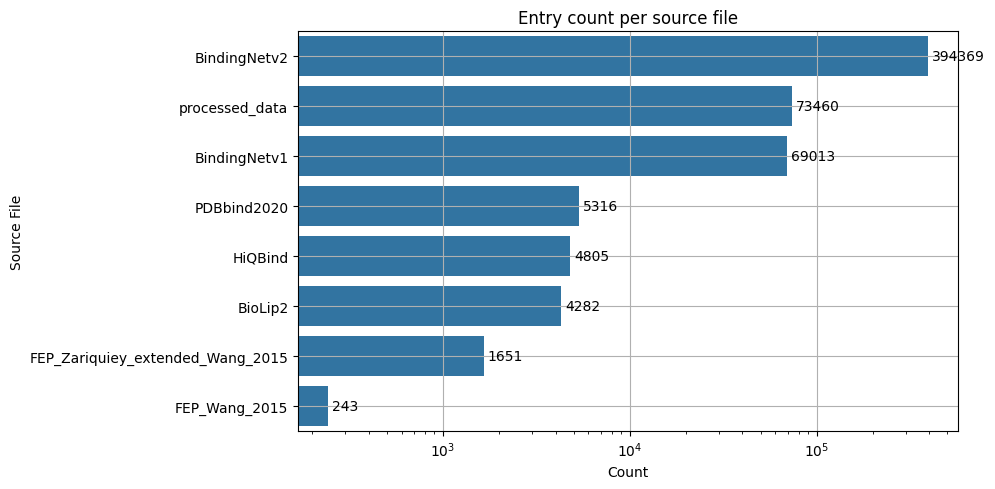

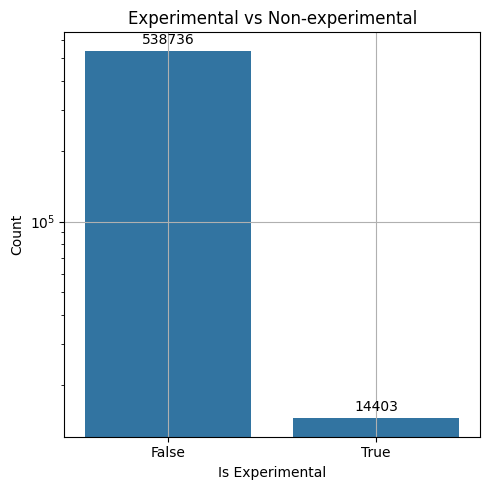

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for source_file with counts
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=df_combined,
    y="source_file",
    order=df_combined["source_file"].value_counts().index
)
plt.title("Entry count per source file")
plt.xlabel("Count")
plt.ylabel("Source File")
plt.xscale('log')
plt.grid(True)

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=3)

plt.tight_layout()
plt.show()

# Count plot for is_experimental with counts
plt.figure(figsize=(5, 5))
ax = sns.countplot(data=df_combined, x="is_experimental")
plt.title("Experimental vs Non-experimental")
plt.xlabel("Is Experimental")
plt.ylabel("Count")
plt.yscale('log')
plt.grid(True)

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=3)

plt.tight_layout()
plt.show()


In [38]:
df_combined.columns.tolist()

['protein_pdb_path',
 'ligand_sdf_path',
 'smiles',
 'pKi',
 'source_file',
 'is_experimental',
 'resolution',
 'pEC50',
 'pKd (Wang, FEP)',
 'pKd',
 'pIC50',
 'SMILES',
 'potency',
 'assay']

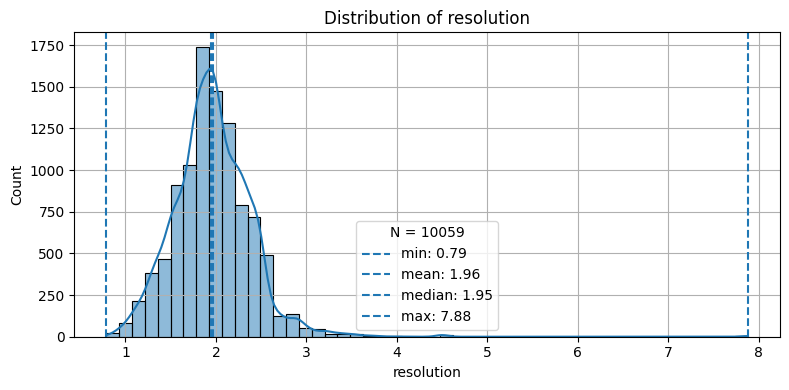

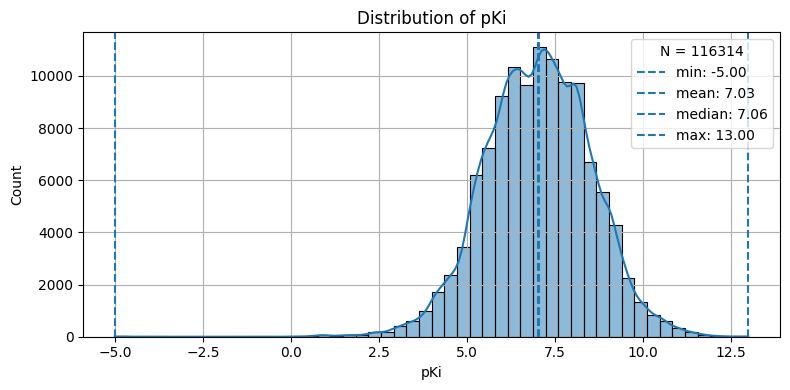

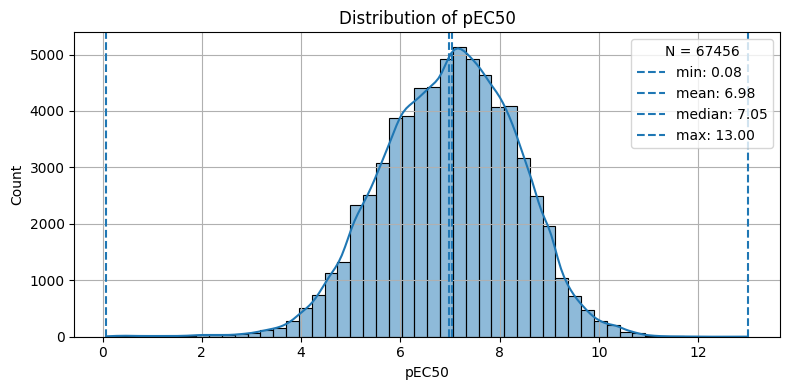

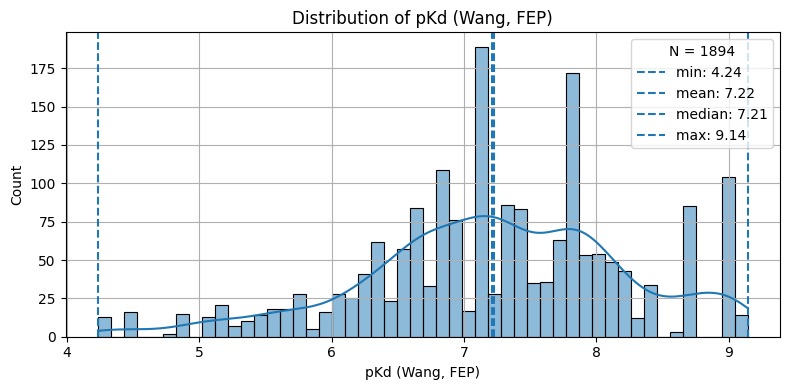

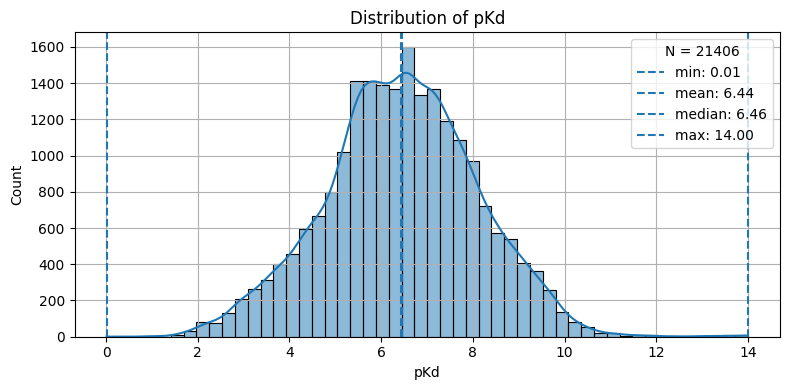

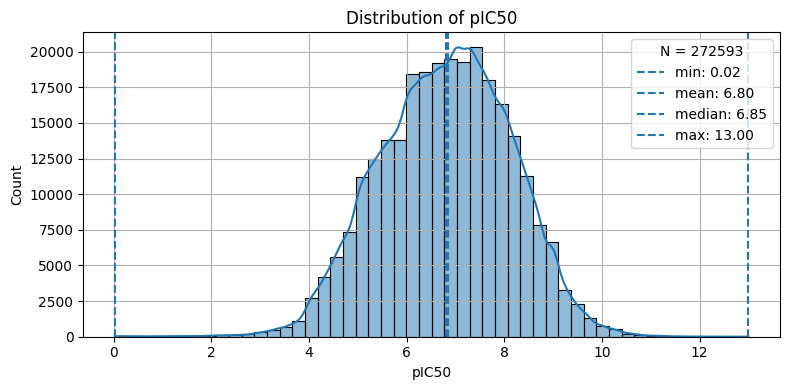

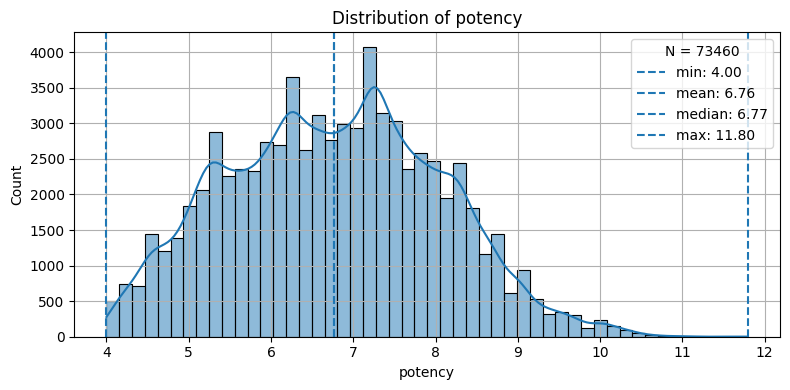

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

exp_cols = ['resolution', 'pKi', 'pEC50',
 'pKd (Wang, FEP)',
 'pKd',
 'pIC50', "potency"]

for col in exp_cols:
    if col in df_combined.columns:
        data = df_combined[col]
        data = data[np.isfinite(data)]

        if len(data) == 0:
            continue

        stats = {
            'N': len(data),
            'min': data.min(),
            'mean': data.mean(),
            'median': data.median(),
            'max': data.max()
        }

        plt.figure(figsize=(8, 4))
        sns.histplot(data, kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.grid(True)

        for label in ['min', 'mean', 'median', 'max']:
            plt.axvline(stats[label], linestyle='--', label=f"{label}: {stats[label]:.2f}")

        plt.legend(title=f"N = {stats['N']}")
        plt.tight_layout()
        plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


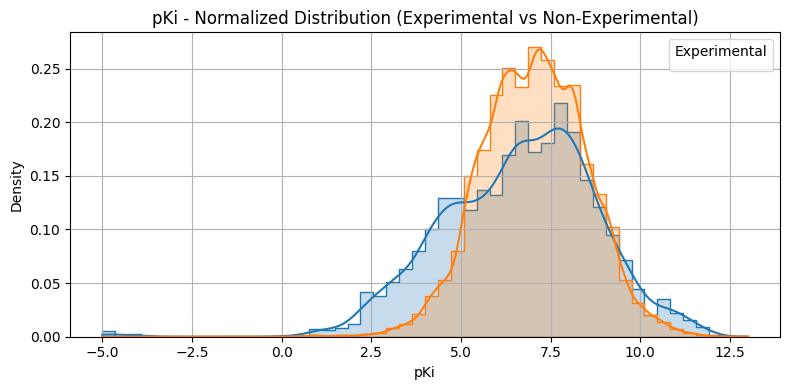

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


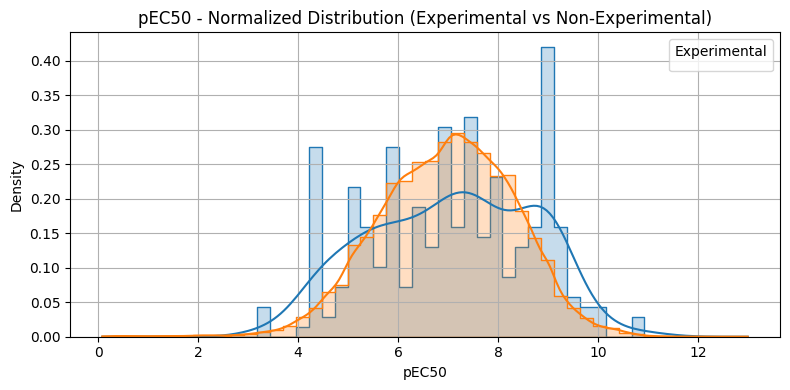

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


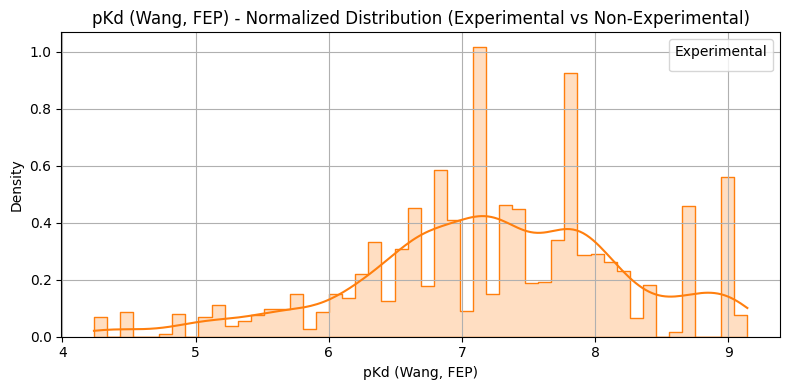

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


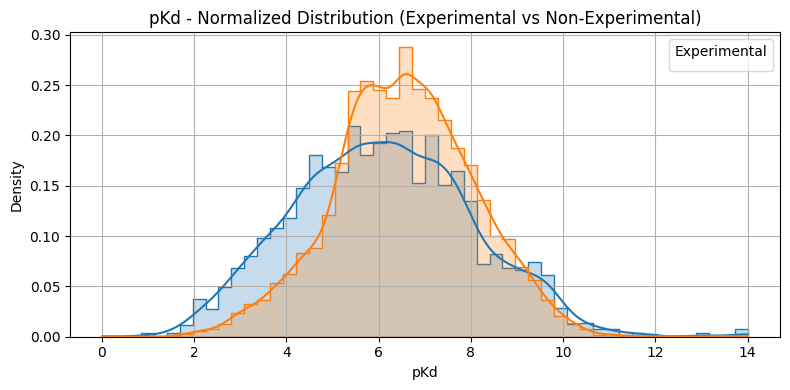

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


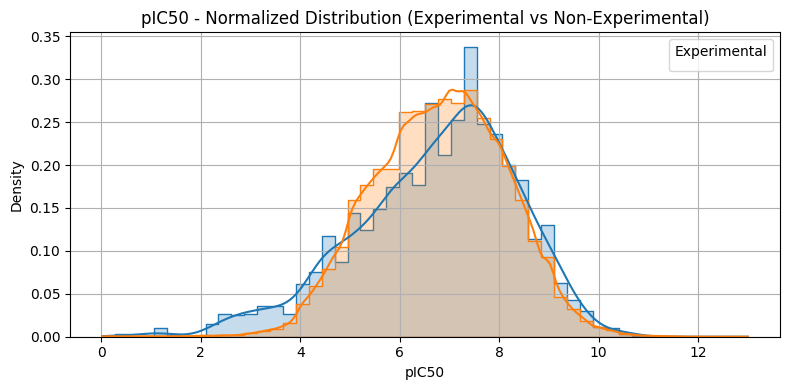

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


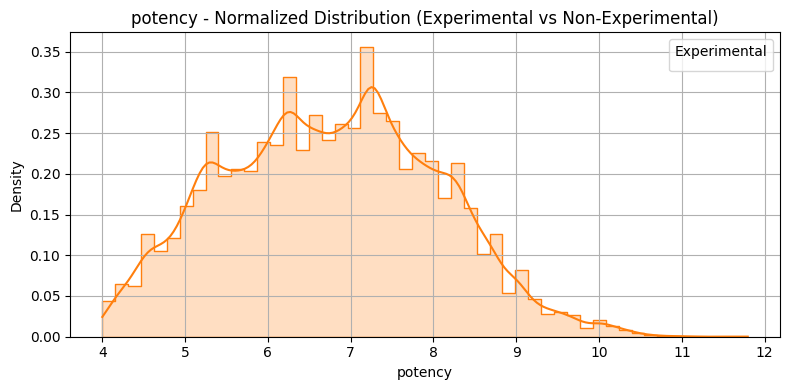

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

exp_cols = [ 'pKi', 'pEC50',
 'pKd (Wang, FEP)',
 'pKd',
 'pIC50', "potency"]  # exclude 'resolution'

for col in exp_cols:
    if col not in df_combined.columns:
        continue

    df_plot = df_combined[[col, 'is_experimental']].copy()
    df_plot = df_plot[np.isfinite(df_plot[col])]

    if df_plot.empty:
        continue

    plt.figure(figsize=(8, 4))
    sns.histplot(
        data=df_plot,
        x=col,
        hue='is_experimental',
        kde=True,
        bins=50,
        palette={True: "tab:blue", False: "tab:orange"},
        element="step",
        stat="density",  # <- normalizes histograms
        common_norm=False
    )

    plt.title(f"{col} - Normalized Distribution (Experimental vs Non-Experimental)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend(title="Experimental")
    plt.tight_layout()
    plt.show()


In [41]:
df_combined = df_combined[df_combined["pKi"].isna() | (df_combined["pKi"] > 3)]
print(len(df_combined))
df_combined = df_combined[df_combined["pEC50"].isna() | (df_combined["pEC50"] > 3)]
print(len(df_combined))
df_combined = df_combined[df_combined["pKd (Wang, FEP)"].isna() | (df_combined["pKd (Wang, FEP)"] > 3)]
print(len(df_combined))
df_combined = df_combined[df_combined["pKd"].isna() | (df_combined["pKd"] > 3)]
print(len(df_combined))
df_combined = df_combined[df_combined["pIC50"].isna() | (df_combined["pIC50"] > 3)]
print(len(df_combined))
df_combined = df_combined[df_combined["resolution"].isna() | (df_combined["resolution"] > 0)]
print(len(df_combined))
df_combined = df_combined[df_combined["resolution"].isna() | (df_combined["resolution"] < 3)]
print(len(df_combined))

df_combined

552410
552145
552145
551649
550820
550820
550663


,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,pIC50,SMILES,potency,assay
0,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,3.259637,BindingNetv2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c1cccc...,6.376751,BindingNetv2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,Cc1ccc(CSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O)cc1,4.397940,BindingNetv2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,NC(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)O)c1...,6.920819,BindingNetv2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)O)C(=O)O,3.148742,BindingNetv2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553133,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,OC[C@H]1O[C@H](O[PH](O)(O)O[PH](O)(O)OC[C@H]2O...,NaN,BioLip2,True,NaN,NaN,NaN,3.124939,NaN,NaN,NaN,NaN
553134,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,C[C@H]1S[C@H]2NC(N)N[C@@H](O)[C@@H]2C1SC1CCC(C...,NaN,BioLip2,True,NaN,NaN,NaN,7.698970,NaN,NaN,NaN,NaN
553135,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CCCCCCC1CCC(C(O)NNC(S)NC)O1,NaN,BioLip2,True,NaN,NaN,NaN,4.096910,NaN,NaN,NaN,NaN
553137,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CCOC(O)C1NNN2C3CCCCC3C(S[C@H](C(C)O)C(O)OCC)NC12,NaN,BioLip2,True,NaN,NaN,NaN,3.920819,NaN,NaN,NaN,NaN


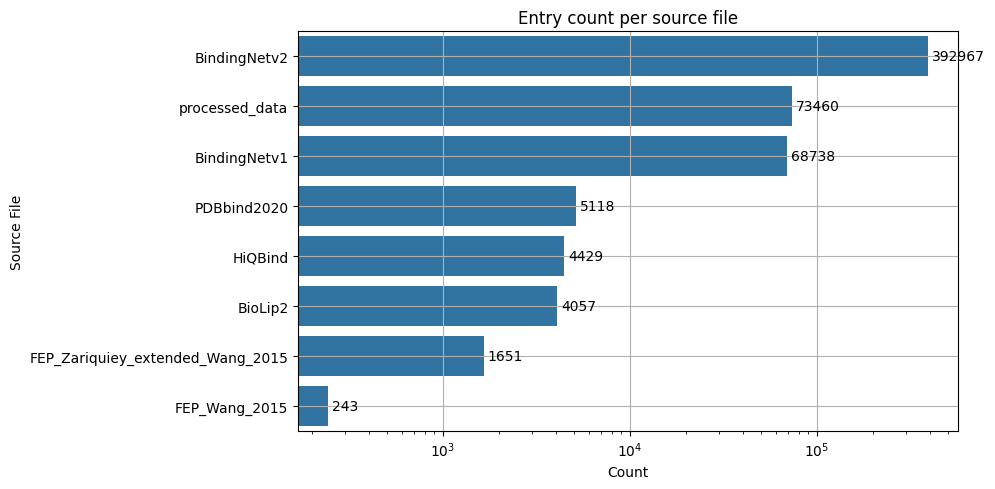

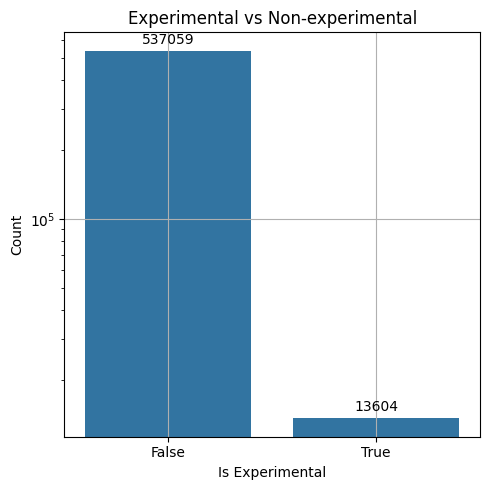

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for source_file with counts
plt.figure(figsize=(10, 5))
ax = sns.countplot(
    data=df_combined,
    y="source_file",
    order=df_combined["source_file"].value_counts().index
)
plt.title("Entry count per source file")
plt.xlabel("Count")
plt.ylabel("Source File")
plt.xscale('log')
plt.grid(True)

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=3)

plt.tight_layout()
plt.show()

# Count plot for is_experimental with counts
plt.figure(figsize=(5, 5))
ax = sns.countplot(data=df_combined, x="is_experimental")
plt.title("Experimental vs Non-experimental")
plt.xlabel("Is Experimental")
plt.ylabel("Count")
plt.yscale('log')
plt.grid(True)

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type="edge", padding=3)

plt.tight_layout()
plt.show()


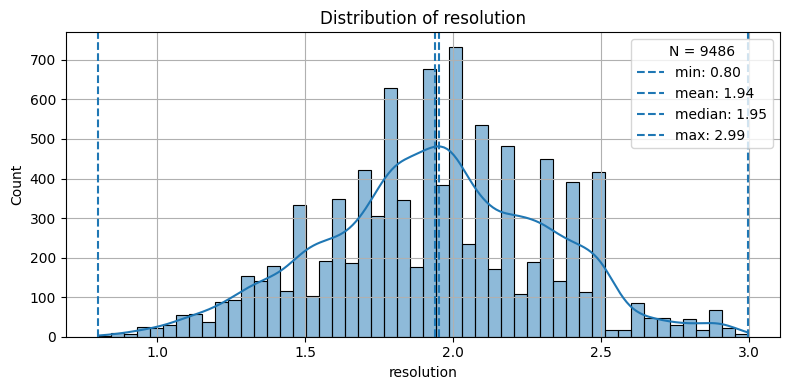

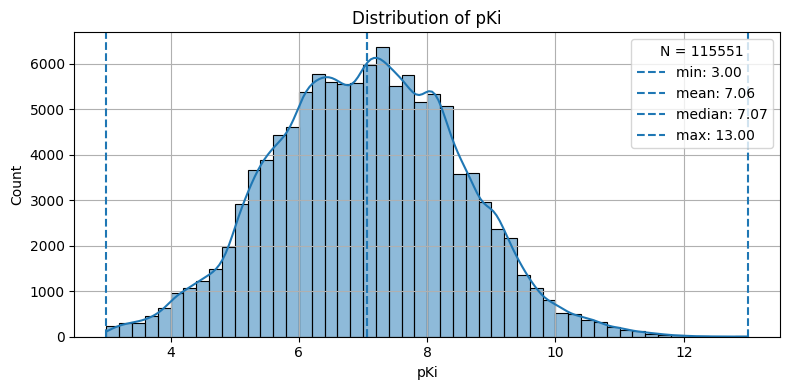

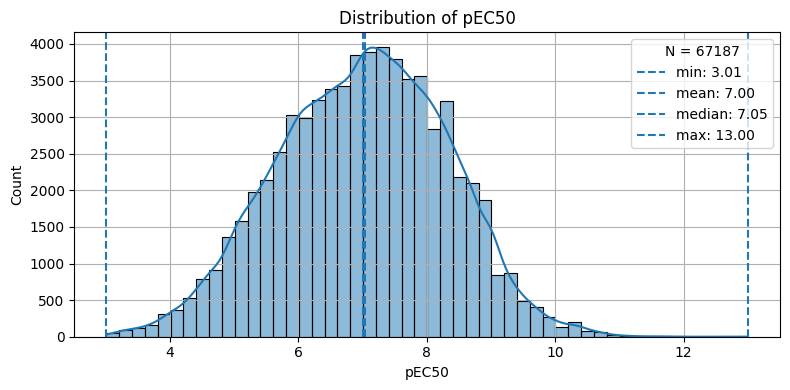

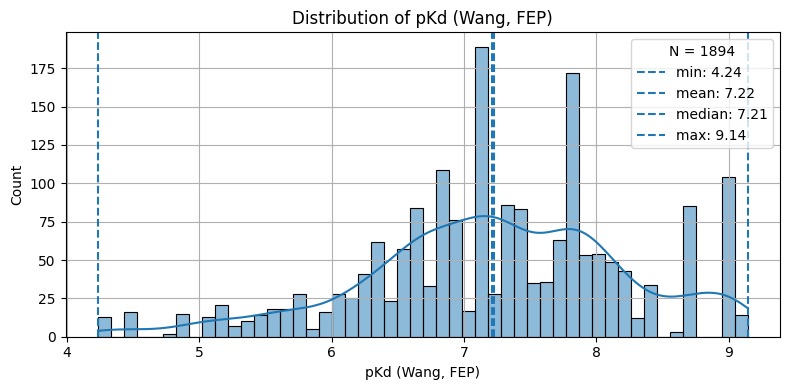

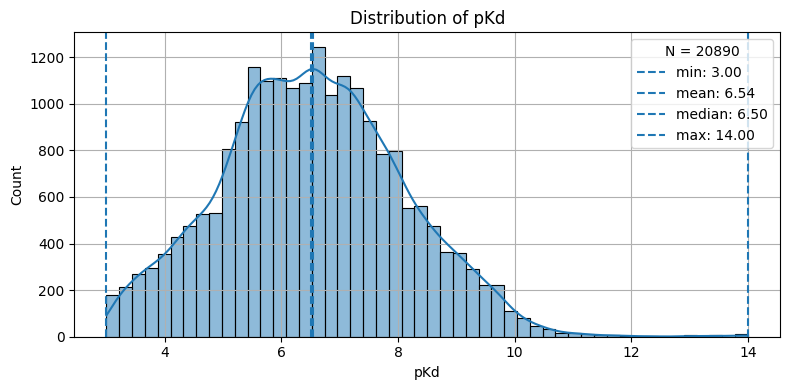

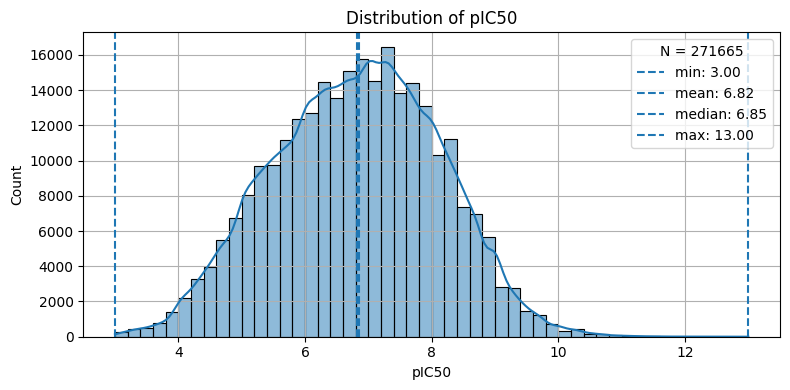

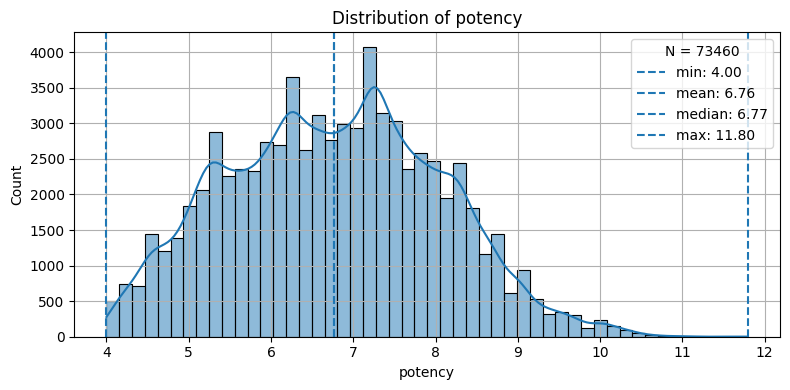

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

exp_cols = ['resolution',  'pKi', 'pEC50',
 'pKd (Wang, FEP)',
 'pKd',
 'pIC50', "potency"]

for col in exp_cols:
    if col in df_combined.columns:
        data = df_combined[col]
        data = data[np.isfinite(data)]

        if len(data) == 0:
            continue

        stats = {
            'N': len(data),
            'min': data.min(),
            'mean': data.mean(),
            'median': data.median(),
            'max': data.max()
        }

        plt.figure(figsize=(8, 4))
        sns.histplot(data, kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.grid(True)

        for label in ['min', 'mean', 'median', 'max']:
            plt.axvline(stats[label], linestyle='--', label=f"{label}: {stats[label]:.2f}")

        plt.legend(title=f"N = {stats['N']}")
        plt.tight_layout()
        plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


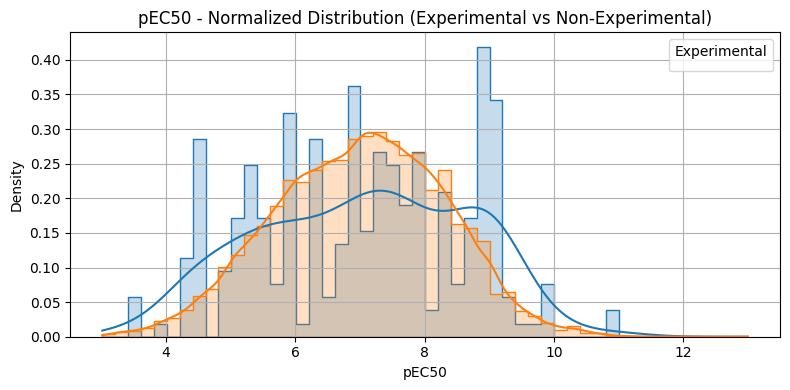

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


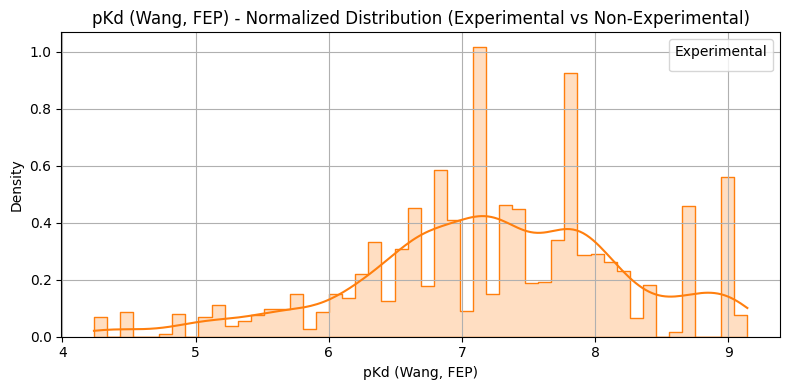

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


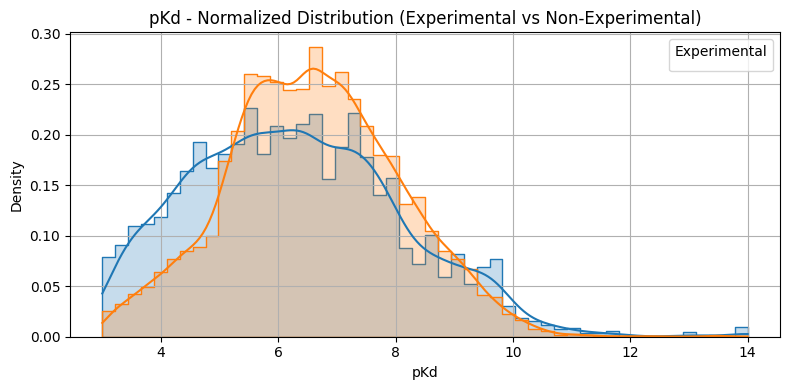

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


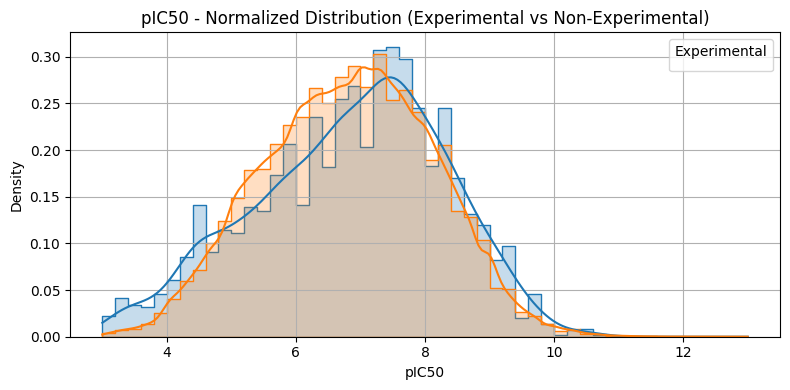

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


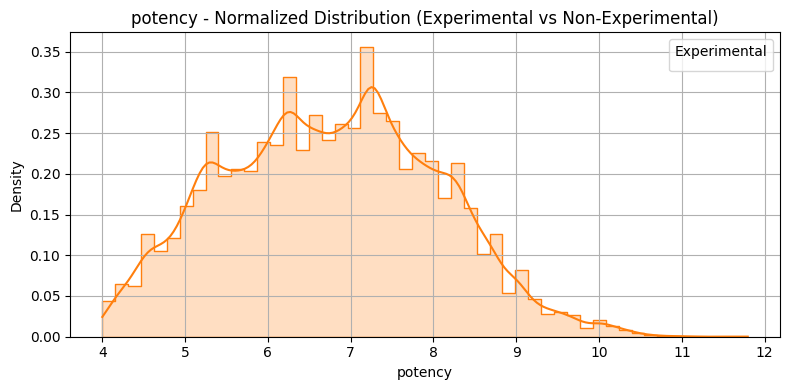

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

exp_cols = ['pKi' 'pKi', 'pEC50',
 'pKd (Wang, FEP)',
 'pKd',
 'pIC50', "potency"]  # exclude 'resolution'

for col in exp_cols:
    if col not in df_combined.columns:
        continue

    df_plot = df_combined[[col, 'is_experimental']].copy()
    df_plot = df_plot[np.isfinite(df_plot[col])]

    if df_plot.empty:
        continue

    plt.figure(figsize=(8, 4))
    sns.histplot(
        data=df_plot,
        x=col,
        hue='is_experimental',
        kde=True,
        bins=50,
        palette={True: "tab:blue", False: "tab:orange"},
        element="step",
        stat="density",  # <- normalizes histograms
        common_norm=False
    )

    plt.title(f"{col} - Normalized Distribution (Experimental vs Non-Experimental)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True)
    plt.legend(title="Experimental")
    plt.tight_layout()
    plt.show()


In [45]:
df_combined.to_parquet("../data/curated/combined/df_combined.parquet", index = False)

In [46]:
import pandas as pd
df_combined = pd.read_parquet("../data/curated/combined/df_combined.parquet")

In [48]:
df_combined.head().style

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,pIC50,SMILES,potency,assay
0,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL60581/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL60581/ligand.sdf,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,3.259637,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None
1,../data/raw/BindingNetv2/moderate/target_CHEMBL3902/CHEMBL58951/protein.pdb,../data/raw/BindingNetv2/moderate/target_CHEMBL3902/CHEMBL58951/ligand.sdf,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,6.376751,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None
2,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL301229/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL301229/ligand.sdf,Cc1ccc(CSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O)cc1,4.397940,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None
3,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL442360/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL442360/ligand.sdf,NC(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,6.920819,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None
4,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL58451/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL58451/ligand.sdf,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)O)C(=O)O,3.148742,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None
